# 제목: 어떻게 하면 그 건물의 전기 사용량을 줄일 수 있을까?

안녕하세요, 끙정입니다.

## 0.1 시작하기 전에...

전력을 사용하는 것에는 많은 이유가 있습니다. 대표적으로는 아래와 같습니다.

 - 조명을 켠다.
 - 냉난방을 한다.
 - 전자기기를 사용한다.


이 외에도 제가 알지 못하는 다양한 전력 소모 원인이 있을 것입니다. 그러나 중요한 것은 해가 거듭할수록 전력 소모량이 기하급수적으로 늘어가고 있다는 점입니다.

한국 에너지 공단은 에너지 효율을 높이기 위해 건물 부문에서 많은 사업을 진행하고 있습니다. 예를 들면 **건물의 에너지 관리 시스템을 구축**하거나, **효율 등급이 좋은 건물에 대한 인증을 제공**하는 사업들이 있습니다. 일반 가정집이라면 전기를 사용하는 만큼 전기세를 내기 때문에 열심히 절약을 하겠지만, 많은 사람이 사용하는 공동 건물 같은 경우는 전기를 절약하는 것이 쉽지 않습니다. 특히나 상업용 건물이라면 더욱 힘들죠.

본 대회에서 제공되는 데이터는 기상 데이터와 건물 정보입니다. 전력 소모에 큰 영향을 끼치는 요인은 냉난방 시스템이기 때문에 기상 요인의 영향은 아주 클 것입니다.<br>
또한 본 데이터에서 제공되는 컬럼 중에 **비전기 냉방 시스템**이나, **태양광 발전 시스템**은 전력 소모량을 줄일 수 있는 아주 좋은 방법입니다. 건물에 대한 어떠한 정보도 없는 상태에서 이 두 정보를 제공했다는 점은 우연에 의한 것은 아닐 것입니다.

**즉, 전력 소모에 영향을 끼치는 주요 요인을 찾고, 전력 소모량을 줄일 수 있는 방법을 찾아야 한다!**

쉽지는 않겠지만, 지금부터 한 번 살펴보고자 합니다.

In [407]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans

from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings("ignore")

In [408]:
PATH = r'C:\Users\Wyatt\wyatt37\data\energy'

컬럼 이름을 간단한 영어로 변환해주겠습니다.

- 전력사용량 -> target
- 기온 -> temp
- 풍속 -> wind
- 습도 -> humid
- 강수량 -> rain
- 일조 -> sunny
- 비전기냉방설비운영 -> cooler
- 태양광보유 -> solar

In [420]:
train_col = ['num', 'date_time', 'target', 'temp', 'wind', 'humid', 'rain', 'sunny', 'cooler', 'solar']
test_col = ['num', 'date_time', 'temp', 'wind', 'humid', 'rain', 'sunny', 'cooler', 'solar']

In [482]:
train = pd.read_csv(PATH + '\\train.csv', encoding='cp949', names=train_col, header=0)
test = pd.read_csv(PATH + '\\test.csv', encoding='cp949', names=test_col, header=0)
sub = pd.read_csv(PATH + '\\sample_submission.csv', encoding='cp949')

# 1. 전처리

## 1.1 datetime

datetime 과 관련된 컬럼을 만들어 줍니다.

In [483]:
def make_time(train):
    train['date_time'] = pd.to_datetime(train.date_time)
    
    # dt.
    train['month'] = train.date_time.dt.month                    # 월(숫자)
    train['day'] = train.date_time.dt.day                        # 일(숫자)
    train['hour'] = train.date_time.dt.hour                      # 시(숫자)
    train['weekday'] = train.date_time.dt.weekday                # 요일(숫자)
    train['dayofyear'] = train.date_time.dt.dayofyear            # 연 기준 몇일째(숫자)

    
    return train

In [484]:
train = make_time(train)
test = make_time(test)

## 1.2 fillna

테스트 셋에는 Cooler와 Solar가 비어 있습니다. 다른 데이터와 함께 채워줍니다.

In [485]:
# test에 cooler와 solar를 넣어주겠습니다.
for i in range(1, 61):
    test.loc[test.num == i, 'cooler'] = train.loc[train.num == i, 'cooler'].mean()
    test.loc[test.num == i, 'solar'] = train.loc[train.num == i, 'solar'].mean()

In [486]:
# test set의 빈 값을 채워줍니다.
test[['temp', 'wind', 'humid', 'rain', 'sunny']] = test[['temp', 'wind', 'humid', 'rain', 'sunny']].interpolate(method='values').round(1)

In [487]:
train.head()

num           date_time    target  temp  wind  humid  rain  sunny  cooler  \
0    1 2020-06-01 00:00:00  8179.056  17.6   2.5   92.0   0.8    0.0     0.0   
1    1 2020-06-01 01:00:00  8135.640  17.7   2.9   91.0   0.3    0.0     0.0   
2    1 2020-06-01 02:00:00  8107.128  17.5   3.2   91.0   0.0    0.0     0.0   
3    1 2020-06-01 03:00:00  8048.808  17.1   3.2   91.0   0.0    0.0     0.0   
4    1 2020-06-01 04:00:00  8043.624  17.0   3.3   92.0   0.0    0.0     0.0   

   solar  month  day  hour  weekday  dayofyear  
0    0.0      6    1     0        0        153  
1    0.0      6    1     1        0        153  
2    0.0      6    1     2        0        153  
3    0.0      6    1     3        0        153  
4    0.0      6    1     4        0        153

In [488]:
test.head()

num           date_time  temp  wind  humid  rain  sunny  cooler  solar  \
0    1 2020-08-25 00:00:00  27.8   1.5   74.0   0.0    0.0     0.0    0.0   
1    1 2020-08-25 01:00:00  27.6   1.4   75.3   0.0    0.0     0.0    0.0   
2    1 2020-08-25 02:00:00  27.5   1.2   76.7   0.0    0.0     0.0    0.0   
3    1 2020-08-25 03:00:00  27.3   1.1   78.0   0.0    0.0     0.0    0.0   
4    1 2020-08-25 04:00:00  26.9   1.2   79.7   0.0    0.0     0.0    0.0   

   month  day  hour  weekday  dayofyear  
0      8   25     0        1        238  
1      8   25     1        1        238  
2      8   25     2        1        238  
3      8   25     3        1        238  
4      8   25     4        1        238

# 2. 분석

## 2.1 데이터 흐름 분석; 기본적인 흐름을 살펴보자

시간의 흐름에 따라 데이터가 어떤 흐름을 보이는지만 살펴보겠습니다.

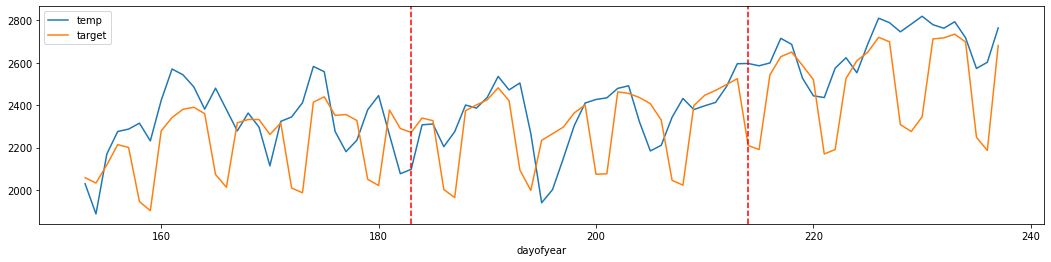

In [453]:
(train.groupby(['dayofyear'])['temp'].mean()*100).plot(figsize=(18, 4))
train.groupby(['dayofyear'])['target'].mean().plot(figsize=(18, 4))
plt.legend(['temp', 'target'])
plt.axvline(x = 183, color = 'r', linestyle = '--',)
plt.axvline(x = 214, color = 'r', linestyle = '--',)
plt.show()

일간 평균 기온과 전력 사용량을 6, 7, 8월로 구분한 플롯입니다.<br>
7월 초순이 끝날 무렵 바닥을 쳤다가, 그 이후로 꾸준히 상승하는 경향을 보입니다.<br>
일반적으로 전력 사용량은 기온과 비슷한 흐름으로 흘러갑니다.

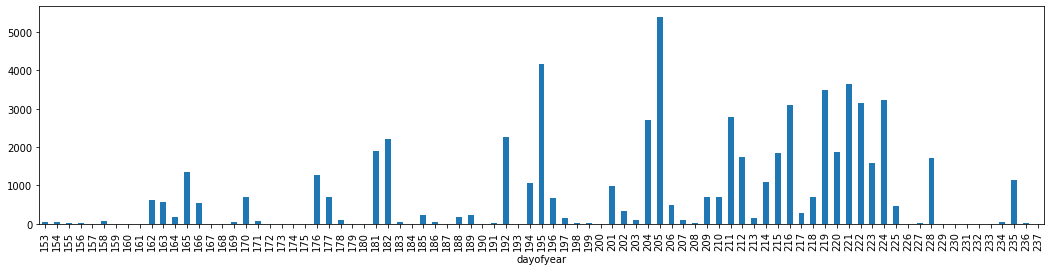

In [454]:
(train.groupby(['dayofyear'])['rain'].sum()).plot(kind='bar', figsize=(18, 4))
plt.show()

7월 말부터 8월 중순까지는 쉬지 않고 매일 비가 내렸습니다. 장마라고 충분히 표현할 수 있을 것 같습니다.

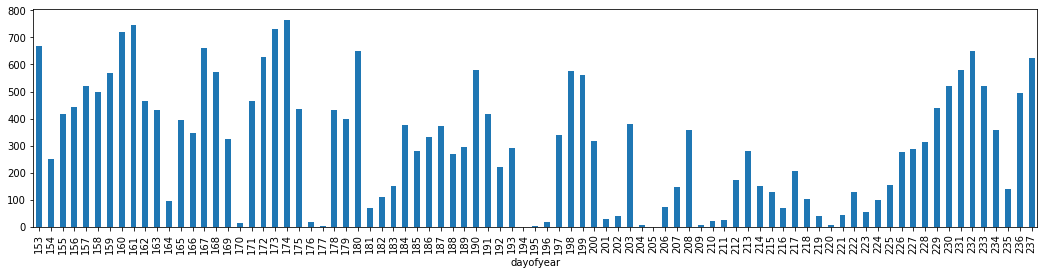

In [455]:
train.groupby(['dayofyear'])['sunny'].sum().plot(kind='bar', figsize=(18, 4))
plt.show()

일별 일조시간을 바차트로 그려본 것입니다. 장마 시즌에는 일조시간이 줄어들며, 6월과 8월 말에 높은 일조시간을 보이는 것을 알 수 있습니다.

- 6월, 7월보다 8월 말로 갈수록 더욱 기온은 높아진다.
- 기온이 높아짐에 따라 전력 사용량도 같이 높아지는 경향을 보인다.
- 7월 말부터 장마의 영향을 받으며 비내리는 날이 많아진다.
- 8월 말에는 장마가 끝나며, 비가 오는 날이 거의 없다.
- 일조 시간은 6월에 가장 높았고, 장마 시즌에 줄어들었으며, 8월에 다시 오르고 있다.

## 2.2 건물별 전력 사용 패턴 분석

### 2.2.1 건물별 시간대에 따른 유형 파악

10개씩 살펴보겠습니다.

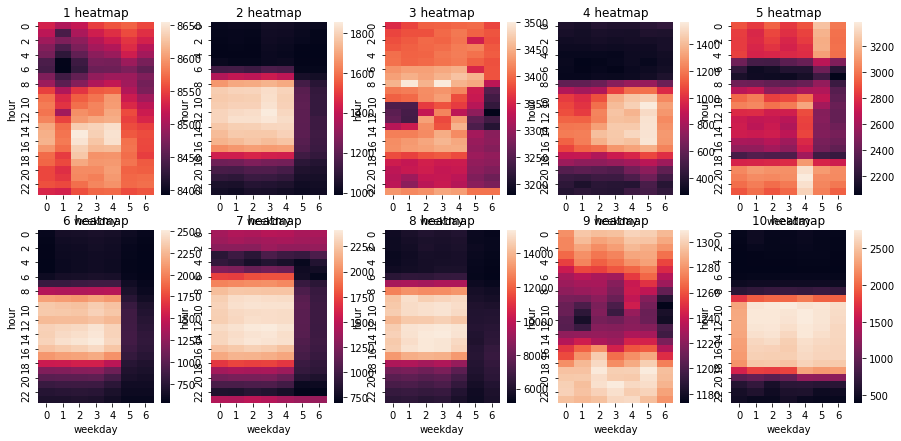

In [456]:
fig = plt.figure(figsize=(15, 7))
for i in range(1, 11):
    plt.subplot(2, 5, i)
    plt.title("{} heatmap".format(i))
    sns.heatmap(train.loc[train.num == i].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

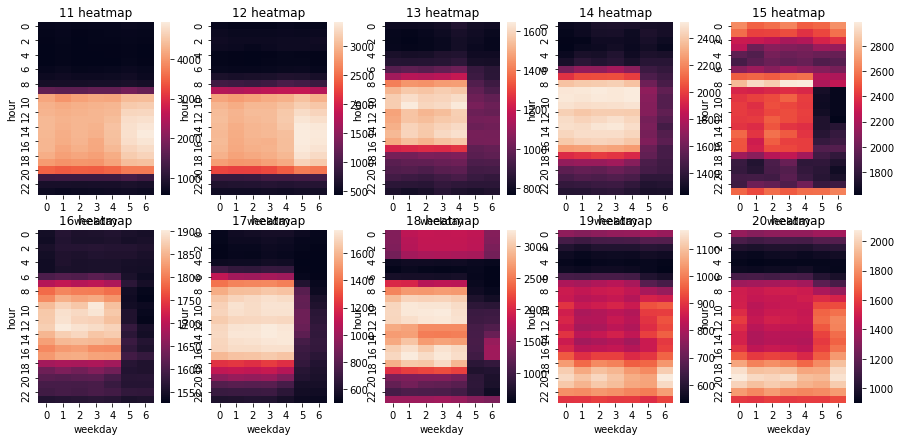

In [457]:
fig = plt.figure(figsize=(15, 7))
for i in range(11, 21):
    plt.subplot(2, 5, i-10)
    plt.title("{} heatmap".format(i))
    sns.heatmap(train.loc[train.num == i].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

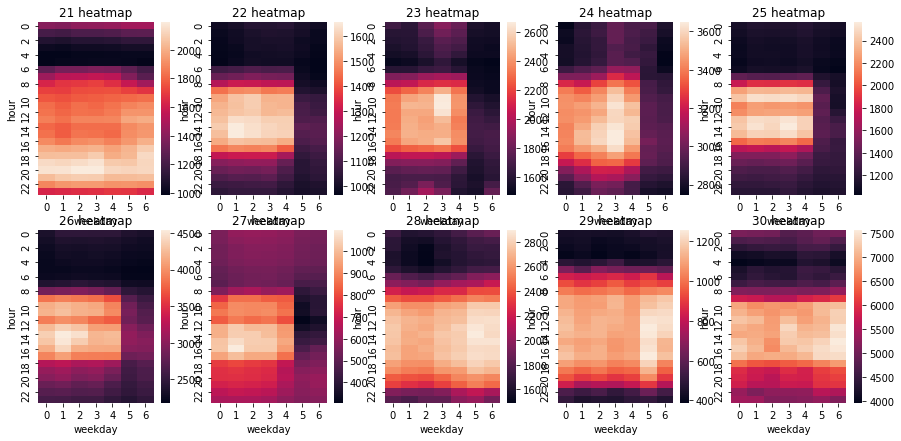

In [458]:
fig = plt.figure(figsize=(15, 7))
for i in range(21, 31):
    plt.subplot(2, 5, i-20)
    plt.title("{} heatmap".format(i))
    sns.heatmap(train.loc[train.num == i].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

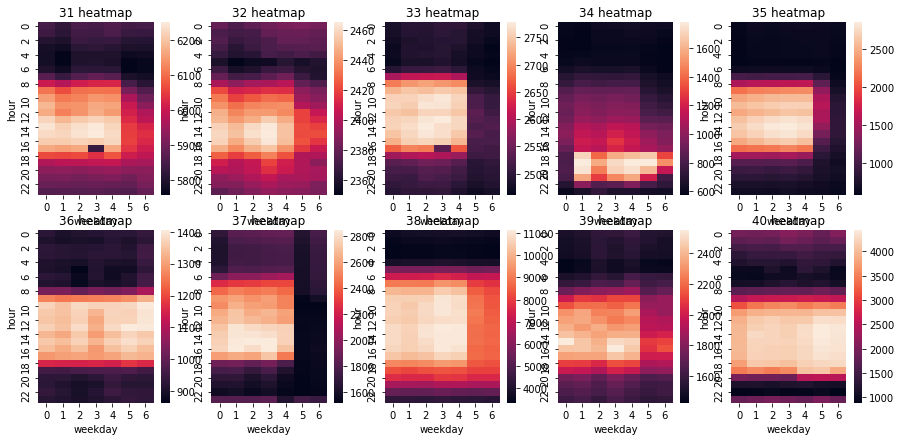

In [459]:
fig = plt.figure(figsize=(15, 7))
for i in range(31, 41):
    plt.subplot(2, 5, i-30)
    plt.title("{} heatmap".format(i))
    sns.heatmap(train.loc[train.num == i].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

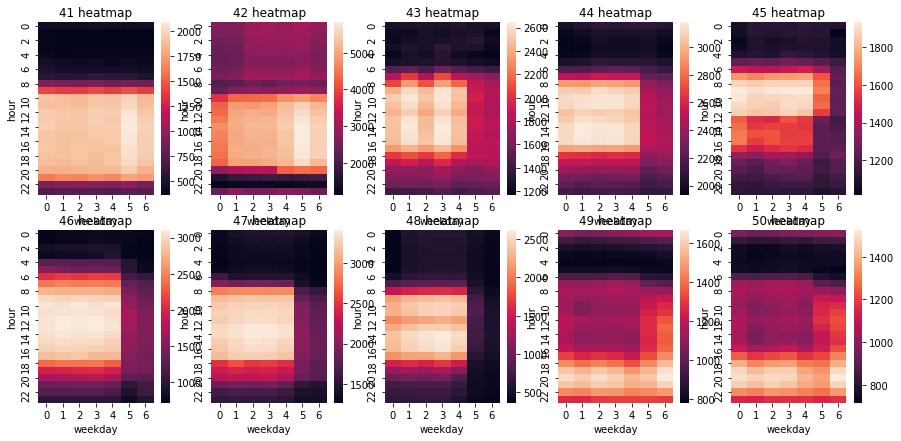

In [460]:
fig = plt.figure(figsize=(15, 7))
for i in range(41, 51):
    plt.subplot(2, 5, i-40)
    plt.title("{} heatmap".format(i))
    sns.heatmap(train.loc[train.num == i].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

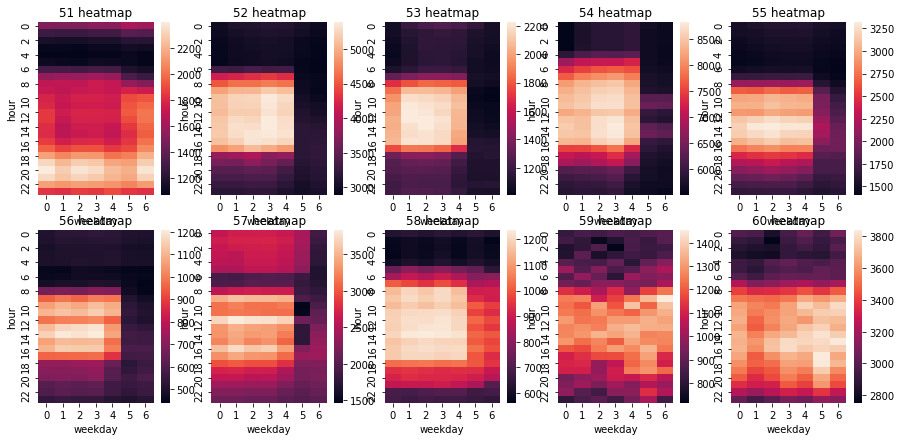

In [461]:
fig = plt.figure(figsize=(15, 7))
for i in range(51, 61):
    plt.subplot(2, 5, i-50)
    plt.title("{} heatmap".format(i))
    sns.heatmap(train.loc[train.num == i].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

대다수의 건물들이 전력사용량이 집중되는 시간대와 요일이 정해져 있습니다.<br>
또한 건물들끼리 비슷한 패턴을 보이고 있습니다. 건물들을 군집화하여 살펴보겠습니다.

### 2.2.2 군집화를 통한 유형 분류

건물의 유형과 용도를 파악하기 위해 비슷한 건물들끼리 묶어보겠습니다. '동준이'님의 코드를 참고하였습니다. 감사합니다.

https://www.dacon.io/competitions/official/235736/codeshare/2743?page=1&dtype=recent

kmeans 외에도 DBSCAN, 계층적군집 등을 사용해보았으나, kmeans가 가장 좋은 군집화를 보였습니다.

In [489]:
train_origin = train.copy()

In [490]:
# min_max_scaling
for i in range(1, 61):
    mean_ = train.loc[train.num == i].target.mean()
    std_ = train.loc[train.num == i].target.std()
    train.loc[train.num == i, 'target'] = ((train.loc[train.num == i, 'target']) - mean_) / std_

In [491]:
# 요일에 따른 평균 값 산출
weekday_mean = (
    train.groupby(['num', 'weekday'])['target'].mean()
    .reset_index()
    .pivot('num', 'weekday', 'target')
    .reset_index()
)

In [492]:
# 시간에 따른 평균 값 산출
hour_mean = (
    train.groupby(['num', 'hour'])['target'].mean()
    .reset_index()
    .pivot('num', 'hour', 'target')
    .reset_index()
    .drop('num', axis=1)
)

In [493]:
# 요일별, 시간별 평균 전력 사용량 테이블 구축
cl_df = pd.concat([weekday_mean, hour_mean], axis=1)

In [494]:
# 보기 편하게 컬럼 이름 지정
columns = (
    ['num']
    + ['day_mean_' + str(i) for i in range(7)]
    + ['hour_mean_' + str(i) for i in range(24)]
)

cl_df.columns = columns

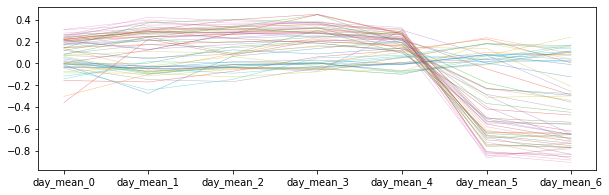

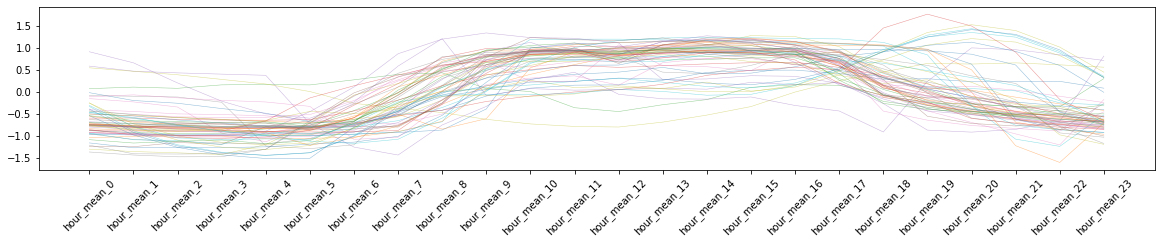

In [495]:
# visualization
fig = plt.figure(figsize = (10,3))
for i in range(len(cl_df)):
    plt.plot(cl_df.iloc[i, 1:8], alpha = 0.5, linewidth = 0.5)
    
fig = plt.figure(figsize = (20,3))
for i in range(len(cl_df)):
    plt.plot(cl_df.iloc[i, 8:32], alpha = 0.5, linewidth = 0.5)
    plt.xticks(rotation=45)

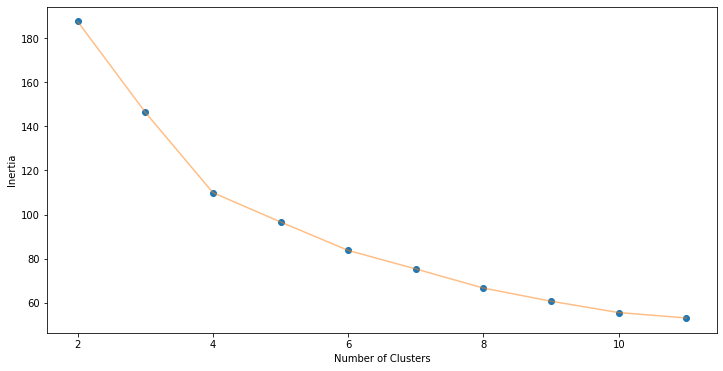

In [496]:
# elbow method를 통해 군집의 개수 결정
def change_n_clusters(n_clusters, data):
    sum_of_squared_distance = []
    for n_cluster in n_clusters:
        kmeans = KMeans(n_clusters=n_cluster)
        kmeans.fit(data)
        sum_of_squared_distance.append(kmeans.inertia_)
        
    plt.figure(1 , figsize = (12, 6))
    plt.plot(n_clusters , sum_of_squared_distance , 'o')
    plt.plot(n_clusters , sum_of_squared_distance , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')

change_n_clusters([2,3,4,5,6,7,8,9,10,11], cl_df.iloc[:,1:])

엘보우 포인트가 4를 가리키고 있습니다. (사실 여러가지 해봤는데 4가 가장 좋았습니다.)

In [497]:
model = KMeans(n_clusters = 4, random_state = 42)
pred = model.fit_predict(cl_df.iloc[:, 1:])

In [498]:
cl_df['km_cluster'] = pred

In [499]:
train_cl = pd.merge(train, cl_df[['num', 'km_cluster']], how='left', on='num')

In [500]:
test_cl = test.copy()

In [501]:
for i in range(1, 61):
    test_cl.loc[test_cl.num == i, 'km_cluster'] = (
        train_cl.loc[train_cl.num == i, 'km_cluster'].max()
    )

In [502]:
km_0 = list(train_cl.loc[train_cl.km_cluster == 0].num.unique())
km_1 = list(train_cl.loc[train_cl.km_cluster == 1].num.unique())
km_2 = list(train_cl.loc[train_cl.km_cluster == 2].num.unique())
km_3 = list(train_cl.loc[train_cl.km_cluster == 3].num.unique())

### 2.2.3 군집 유형 비교

In [503]:
train_cl.groupby(['km_cluster'])['num'].count().to_frame()/2040

num
km_cluster      
0           33.0
1            5.0
2           15.0
3            7.0

0번 유형이 가장 많은 비중을 차지하며, 다음으로 2번, 3번, 1번 순입니다.

유형별로 건물을 살펴보겠습니다.

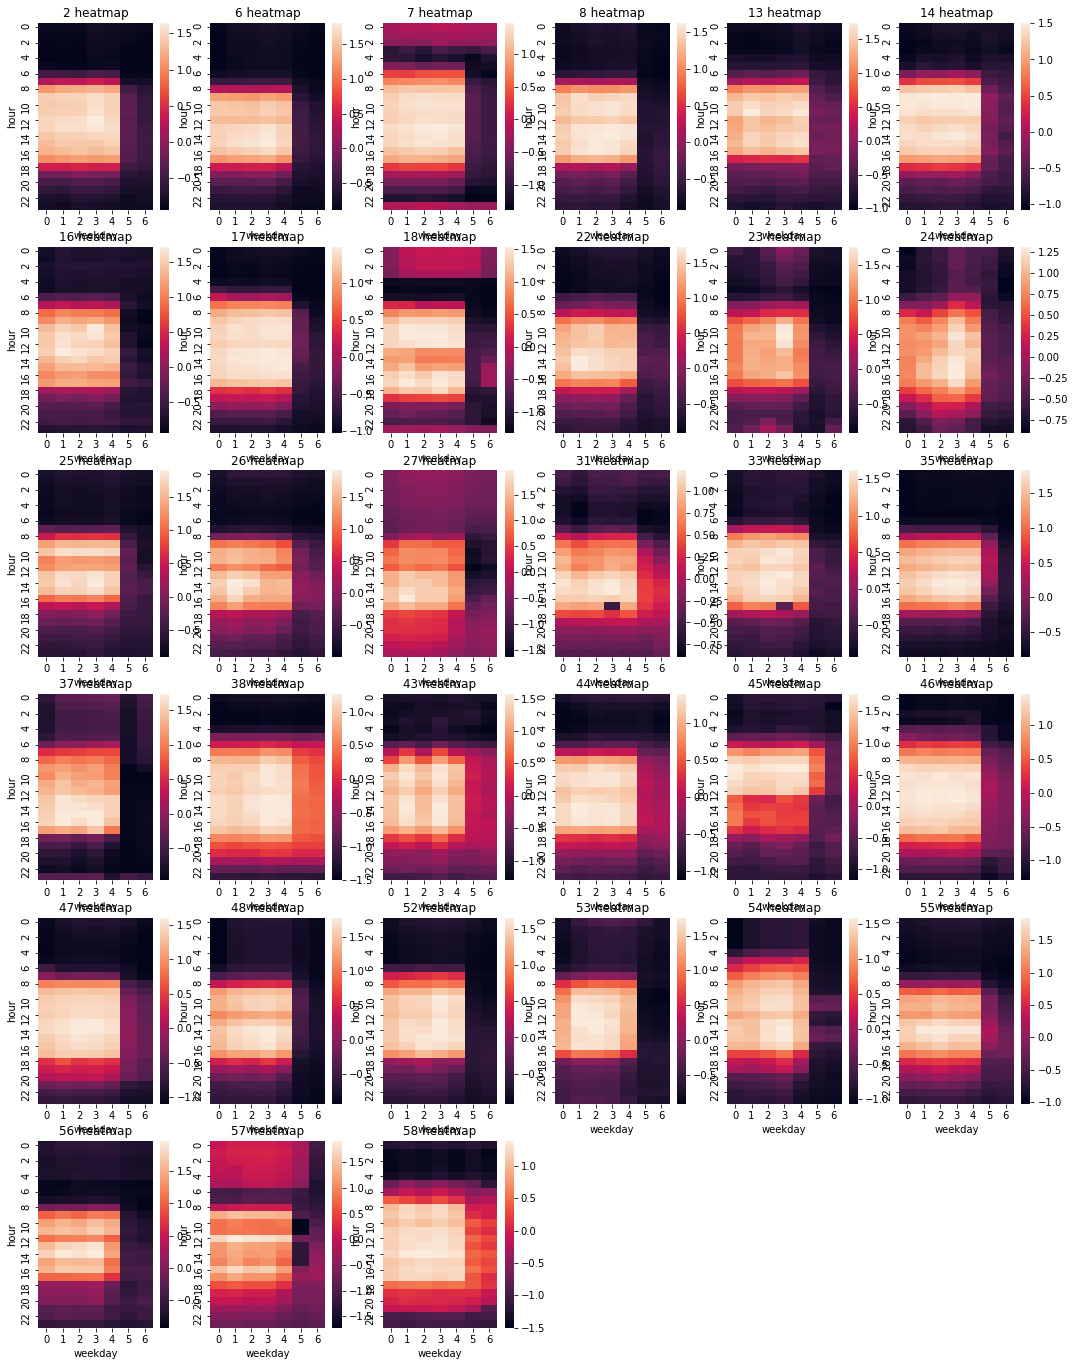

In [515]:
fig = plt.figure(figsize=(18, np.ceil(len(km_0)/6)*4))
for i, n in enumerate(km_0):
    plt.subplot(np.ceil(len(km_0)/6), 6, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

건물별로 편차는 존재하지만, 대체로 평일 업무 시간대에 전력사용량이 집중되어 있습니다.

다만 그 중에서 심야 시간에 전력 사용이 일어난 건물, 주말에 전력 사용이 일어난 건물이 있습니다.
- 심야 시간 전력 사용: 7, 18, 27, 57
- 주말 시간 전력 사용: 38, 58

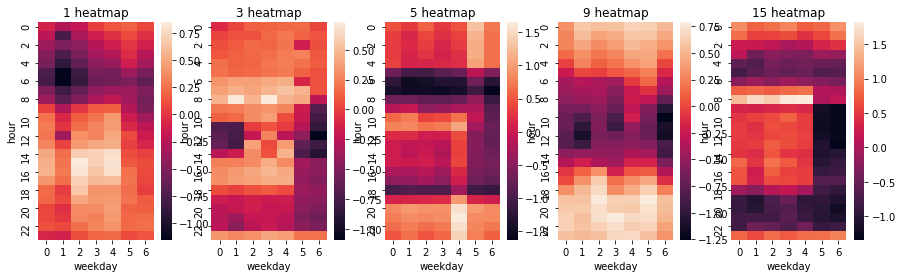

In [514]:
fig = plt.figure(figsize=(15, np.ceil(len(km_1)/5)*4))
for i, n in enumerate(km_1):
    plt.subplot(np.ceil(len(km_1)/5), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

정체를 알 수 없는 1번 클러스터입니다. 건물 모두 사용 패턴이 다소 다르며, 예상치 못한 시간에 전력 사용이 없습니다.

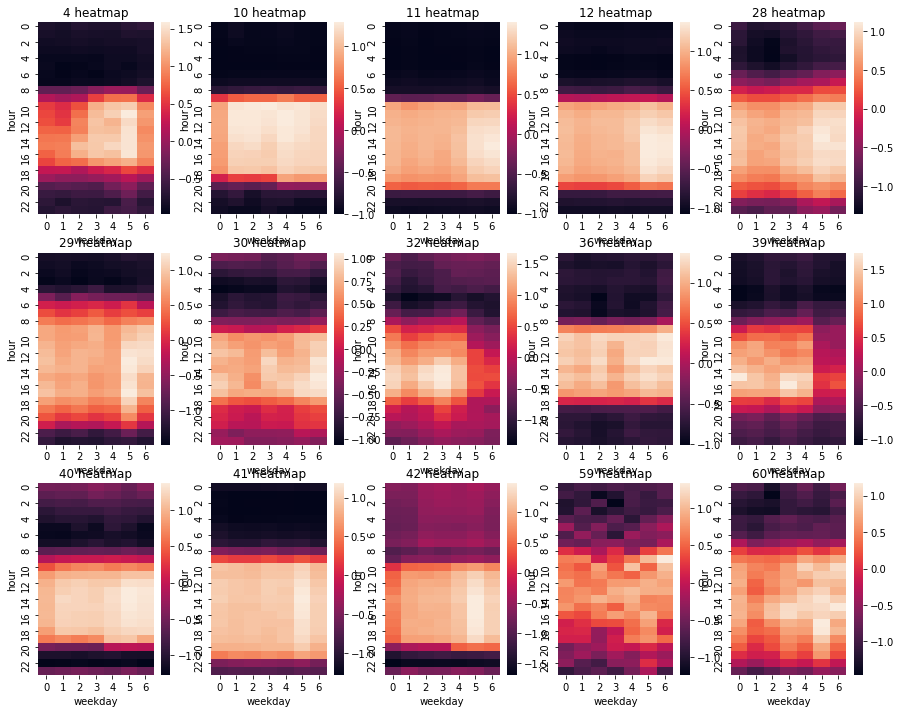

In [516]:
fig = plt.figure(figsize=(15, np.ceil(len(km_2)/5)*4))
for i, n in enumerate(km_2):
    plt.subplot(np.ceil(len(km_2)/5), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

평일, 주말 상관없이 상업 시간에 전력 사용이 집중된 건물들입니다.

- 32, 39번은 주말 전력 사용량이 그다지 많지 않습니다.

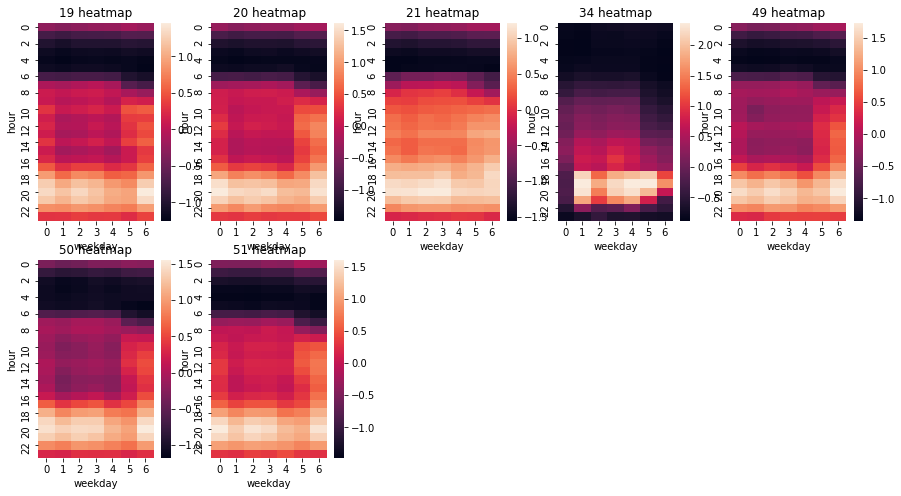

In [517]:
fig = plt.figure(figsize=(15, np.ceil(len(km_3)/5)*4))
for i, n in enumerate(km_3):
    plt.subplot(np.ceil(len(km_3)/5), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

주말평일 상관없이 상업 시간대에 전력 사용량이 많으며, 특히나 주말이나 밤에 사용량이 많습니다. 주말이나 밤에 사람이 몰리는 번화가에 있는 건물일 가능성이 높습니다.

- 34번 건물은 오로지 저녁 시간에만 영업이 이루어지고 있는 것 같습니다.

### 2.2.4 정리

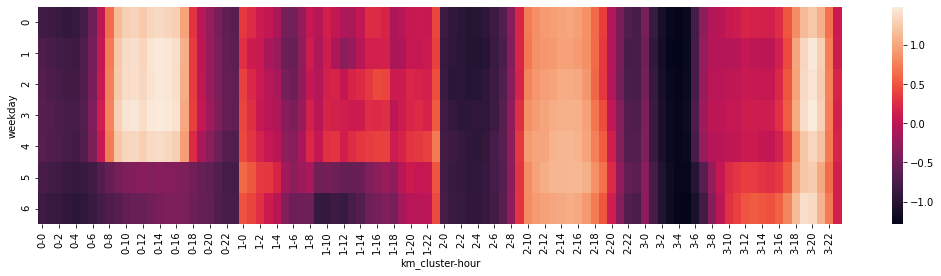

In [504]:
plt.figure(figsize=(18, 4))
sns.heatmap(train_cl.groupby(['km_cluster', 'hour', 'weekday'])['target'].mean().unstack().T)
plt.show()

- 0번 유형: 업무 시간인 9-6 시간대에 가장 높은 전력사용량을 보이며, 주말과 새벽 시간에 사용량이 줄어드는 것을 알 수 있음. -> **고층에는 사무실, 저층에는 상업 시설이 공존하는 오피스형 건물로 추정**
- 1번 유형: 수가 많지 않고, 유형이 다양하여, 추정할 수 없음.
- 2번 유형: 상업 시간인 10-10 시간대에 가장 높은 전력사용량을 보이며, 평일주말 구분이 없이 유지됨.-> **일반적인 상업 시설이 존재하는 상가형 건물로 추정**
- 3번 유형: 2번 유형과 비슷하지만, 저녁 시간에 높은 전력 사용량이 집중되어 있음. 즉, 상업 시설이지만 밤 늦게 영업하는 시설일 가능성이 높음. -> **술집 등이 있는 번화가형 건물로 추정**

건물의 용도와 유형에 따라 특정 시간대에 전력 사용량이 몰리는 것을 알 수 있었습니다.<br>
이러한 유형의 건물들은 전력 사용량이 몰리는 시간대를 중심으로 전력 사용을 절약할 수 있는 방법이 필요할 것 같습니다.

## 2.3 시간 변수에 대한 분석

### 2.3.1 유사한 패턴을 보이던 0, 2, 3번 유형의 건물들

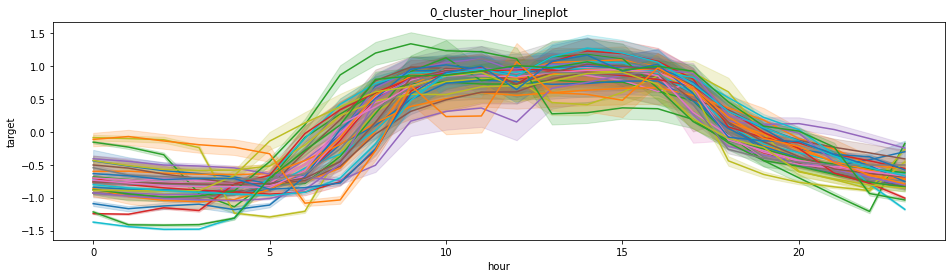

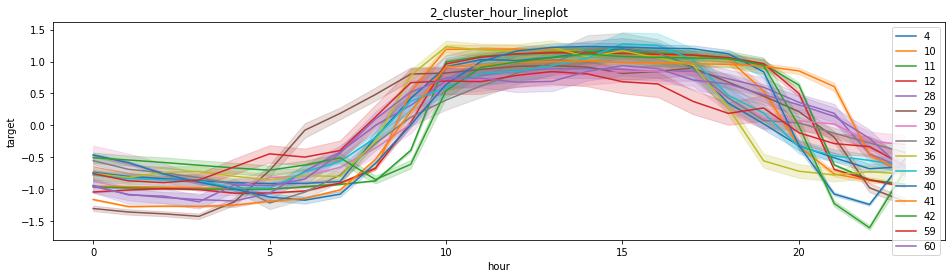

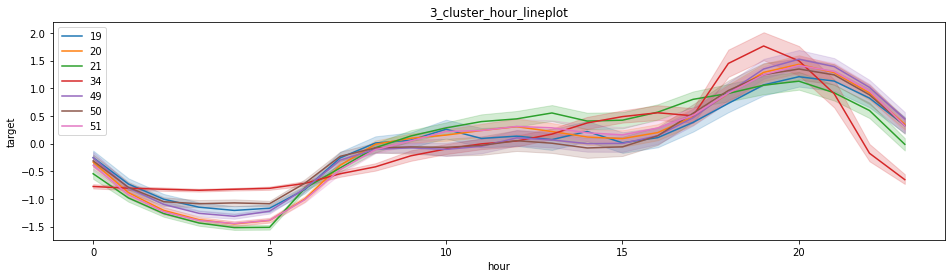

In [609]:
fig = plt.figure(figsize = (16,4))
for i in list(train_cl.loc[train_cl.km_cluster == 0].num.unique()):
    sns.lineplot(data=train_cl.loc[(train_cl.km_cluster == 0) & (train_cl.num == i)], x='hour', y='target')
plt.title('0_cluster_hour_lineplot')

fig = plt.figure(figsize = (16,4))
for i in list(train_cl.loc[train_cl.km_cluster == 2].num.unique()):
    sns.lineplot(data=train_cl.loc[(train_cl.km_cluster == 2) & (train_cl.num == i)], x='hour', y='target')
plt.title('2_cluster_hour_lineplot')
plt.legend(list(train_cl.loc[train_cl.km_cluster == 2].num.unique()))
    
fig = plt.figure(figsize = (16,4))
for i in list(train_cl.loc[train_cl.km_cluster == 3].num.unique()):
    sns.lineplot(data=train_cl.loc[(train_cl.km_cluster == 3) & (train_cl.num == i)], x='hour', y='target')
plt.title('3_cluster_hour_lineplot')
plt.legend(list(train_cl.loc[train_cl.km_cluster == 3].num.unique()))

- 다소 편차는 존재하지만, 대체로 유형별로 비슷한 패턴을 보이고 있습니다.
- 3번 유형에서는 34번이 다른 양상을 보이고 있습니다.

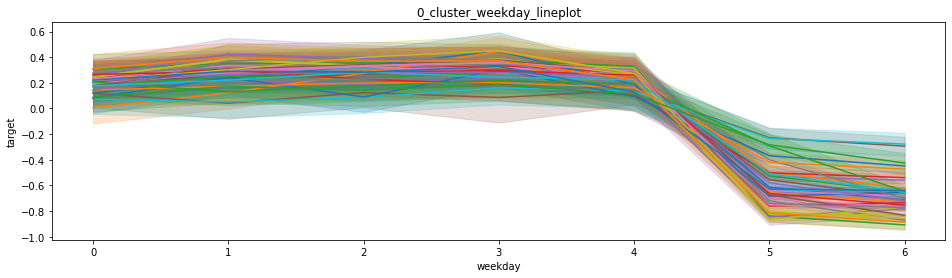

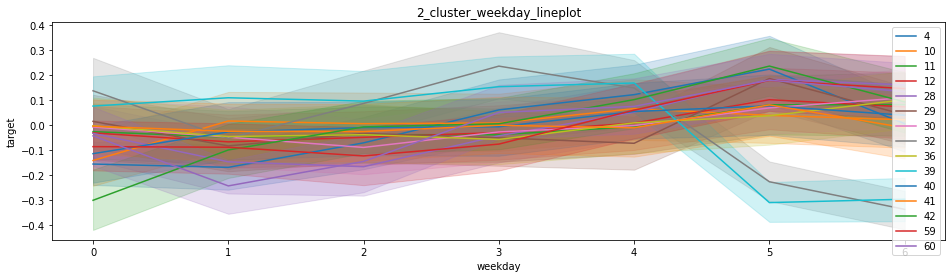

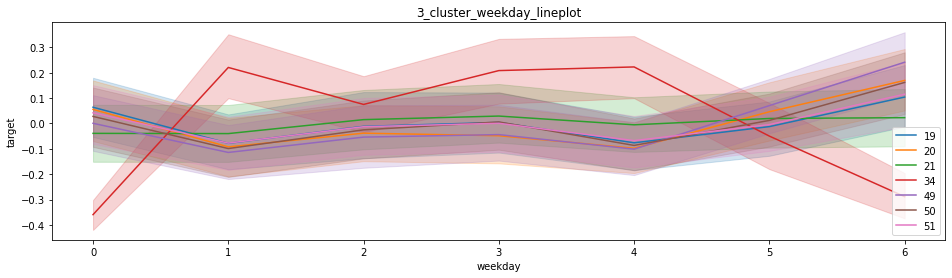

In [610]:
fig = plt.figure(figsize = (16,4))
for i in list(train_cl.loc[train_cl.km_cluster == 0].num.unique()):
    sns.lineplot(data=train_cl.loc[(train_cl.km_cluster == 0) & (train_cl.num == i)], x='weekday', y='target')
plt.title('0_cluster_weekday_lineplot')

fig = plt.figure(figsize = (16,4))
for i in list(train_cl.loc[train_cl.km_cluster == 2].num.unique()):
    sns.lineplot(data=train_cl.loc[(train_cl.km_cluster == 2) & (train_cl.num == i)], x='weekday', y='target')
plt.title('2_cluster_weekday_lineplot')
plt.legend(list(train_cl.loc[train_cl.km_cluster == 2].num.unique()))

fig = plt.figure(figsize = (16,4))
for i in list(train_cl.loc[train_cl.km_cluster == 3].num.unique()):
    sns.lineplot(data=train_cl.loc[(train_cl.km_cluster == 3) & (train_cl.num == i)], x='weekday', y='target')
plt.title('3_cluster_weekday_lineplot')
plt.legend(list(train_cl.loc[train_cl.km_cluster == 3].num.unique()))

- 요일별 평균 전력 사용량에서도 유형별로 유사한 패턴을 보입니다.
- 2번 유형에서 39번과 32번이 다소 상이한 패턴을 보이고 있습니다. 0번 유형과 오히려 유사해보입니다.
- 3번 유형에서는 34번이 다소 상이한 패턴을 보입니다. 어느 유형에도 속하지 않는 패턴입니다.

In [614]:
outlier_sample = [2, 4, 39, 32, 34]

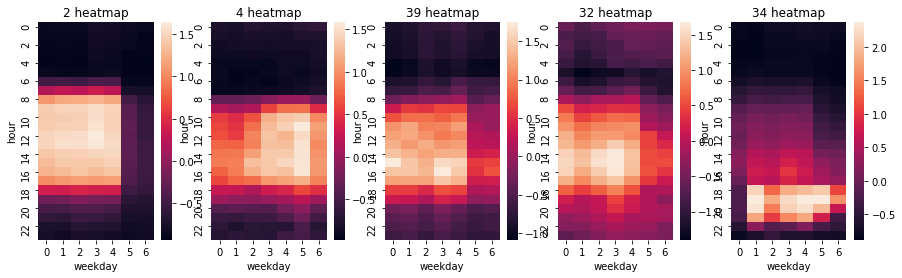

In [615]:
fig = plt.figure(figsize=(15, np.ceil(len(outlier_sample)/5)*4))
for i, n in enumerate(outlier_sample):
    plt.subplot(np.ceil(len(outlier_sample)/5), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

- 39, 32번 건물은 같은 유형인 4번에 비해 주말 전력 사용량이 많지 않습니다. 다만 0번 유형의 2번과는 다르게 주말에도 전력 사용량이 일부 유지되는 패턴입니다.
- 34번은 저녁에만 영업을 하는 유형의 건물입니다.

### 2.3.2 기상 영향을 받지 않던 1번 유형의 건물들

기상 변수의 영향이 적었던 1번 유형의 건물들을 따로 살펴보겠습니다.

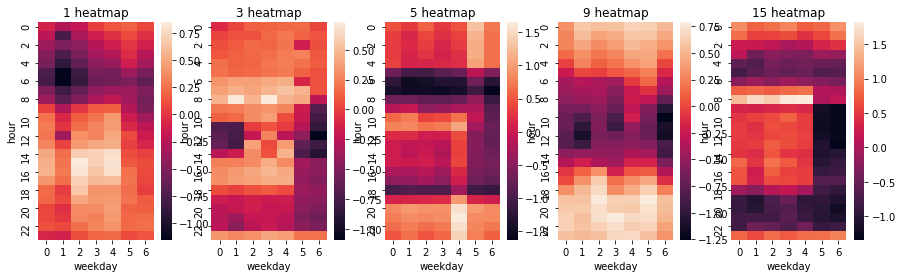

In [551]:
fig = plt.figure(figsize=(15, np.ceil(len(km_1)/5)*4))
for i, n in enumerate(km_1):
    plt.subplot(np.ceil(len(km_1)/5), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

In [616]:
# 기상의 영향을 받지 않는 1번 유형의 건물들과
# 기상의 영향을 매우 많이 받으며, 2번 유형의 건물인 32번 건물 
# 비교를 위한 0번 유형의 2번 건물, 3번 유형의 20번 건물
weird_sample = [2, 20, 32, 1, 3, 5, 9, 15]

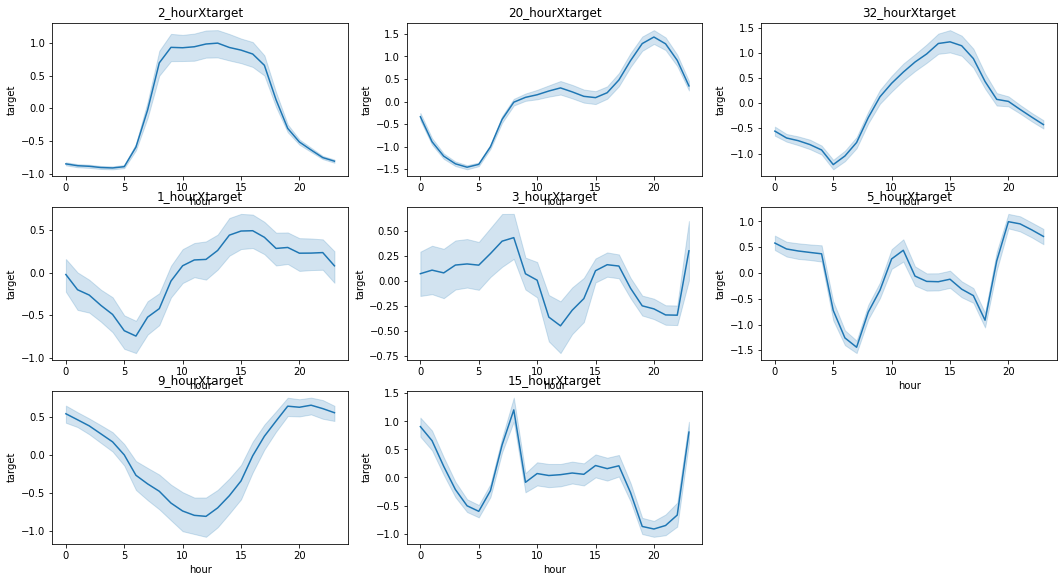

In [620]:
fig = plt.figure(figsize=(18, 40))
for i, n in enumerate(weird_sample):
    plt.subplot(12, 3, i+1)
    plt.title("{}_hourXtarget".format(n))
    sns.lineplot(data=train.loc[train.num == n], x='hour', y='target')

보통의 경우에는 32번 건물처럼 5시 즈음에 저점을 찍고, 15시 즈음에 고점을 찍는 동산형 모양을 띕니다.

- 1번 건물은 32번과 그나마 유사합니다. 다만 편차가 조금 클 뿐이고, 범위가 넓게 형성되고 있습니다.
- 3번 건물은 아침에 고점을 찍고, 정오에 저점을 찍었다가, 저녁에 다시 올랐다가 밤에 다시 내려갑니다. 거리를 돌아다니면서 이런 유형의 건물이 무엇이 있을까 고민하고 있지만, 아직은 찾지 못했습니다.
- 9번 건물은 낮에 전력을 거의 사용하지 않고, 밤부터 급격히 상승합니다. 밤에만 문을 여는 건물이 있는 것 같습니다.
- 15번 건물 또한 아침에 고점을 찍습니다. 그리고 밤에 다시 상승합니다.

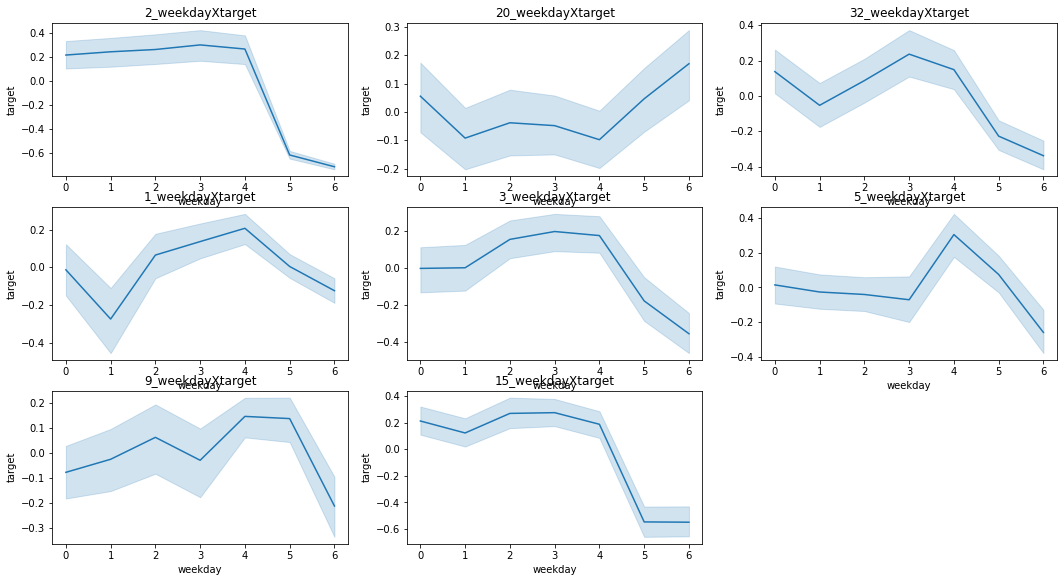

In [621]:
fig = plt.figure(figsize=(18, 40))
for i, n in enumerate(weird_sample):
    plt.subplot(12, 3, i+1)
    plt.title("{}_weekdayXtarget".format(n))
    sns.lineplot(data=train.loc[train.num == n], x='weekday', y='target')

요일별 패턴은 그래도 유사한 점이 있습니다.

- 32번과 유사하게, 모든 건물에서 주말(5~6)에는 사용량이 줄어듭니다.
- 32번과 유사하게, 많은 건물에서 목 ~ 금요일(3~4)에 가장 높은 사용량을 보이고 있습니다.
- 그러나 이 또한 유사한 규칙성을 보이지는 않고 있습니다.

### 2.3.3 정리

- 0번, 2번, 3번 유형의 건물들은 기상 변수의 영향을 다소 받으며, 시간 변수의 영향도 비슷한 패턴을 보이고 있습니다.
- 그러나 1번 유형의 변수는 기상 변수의 영향도 적으면서, 시간 변수의 패턴도 상이하게 나타나고 있습니다.
- 1번 유형의 건물들을 같은 클러스터로 묶는 것은 다소 무리가 있을 것으로 판단되기도 합니다.

## 2.4 기상 변수에 대한 상관 분석: 날씨는 얼마나 중요할까?

### 2.4.1 상관계수 구하기

피어슨 상관계수를 사용했습니다.

In [526]:
from scipy.stats import pearsonr

In [527]:
corrs = []
for i in range(1, 61):
    corr, _ = pearsonr(train.loc[train.num == i].temp,
                       train.loc[train.num == i].target)
    corrs.append(corr)

In [528]:
corrs_temp = train_cl.groupby(['km_cluster', 'num'])['target'].mean().to_frame()

In [529]:
temp = train_cl.groupby(['num'])['cooler', 'solar'].max()

In [531]:
# 건물별로, 기상요인별로 상관계수를 계산해줍니다.
corrs = []
for i in range(1, 61):
    corr, _ = pearsonr(train.loc[train.num == i].temp,
                       train.loc[train.num == i].target)
    corrs.append(corr)
temp['temp_corr'] = corrs

corrs = []
for i in range(1, 61):
    corr, _ = pearsonr(train.loc[train.num == i].humid,
                       train.loc[train.num == i].target)
    corrs.append(corr)
temp['humid_corr'] = corrs

corrs = []
for i in range(1, 61):
    corr, _ = pearsonr(train.loc[train.num == i].sunny,
                       train.loc[train.num == i].target)
    corrs.append(corr)
temp['sunny_corr'] = corrs

corrs = []
for i in range(1, 61):
    corr, _ = pearsonr(train.loc[train.num == i].wind,
                       train.loc[train.num == i].target)
    corrs.append(corr)
temp['wind_corr'] = corrs

In [532]:
corrs_cl_temp = pd.merge(corrs_temp, temp, how='left', on='num').set_index(corrs_temp.index).round(2)

### 2.4.2 기온의 영향을 많이 받는 건물

In [533]:
corrs_temp_temp = (corrs_cl_temp.temp_corr
                   .reset_index()
                   .sort_values(by=['temp_corr'], ascending=False)
                  .set_index(['num'], drop=False))

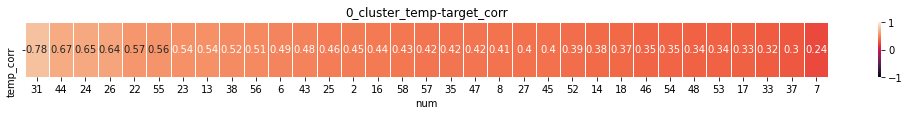

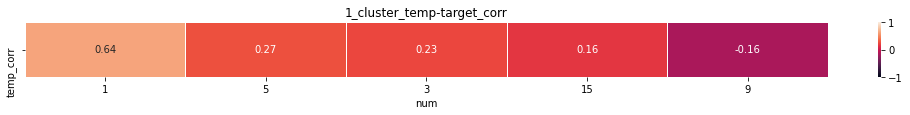

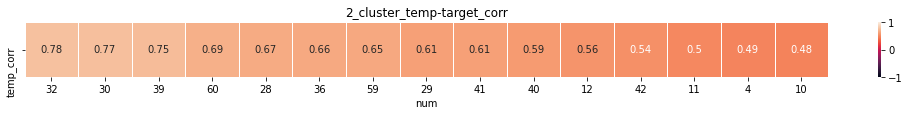

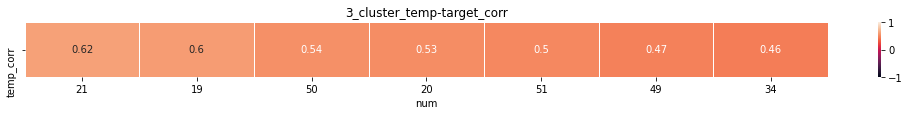

In [534]:
plt.figure(figsize=(18, 1))
plt.title('0_cluster_temp-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 0]['temp_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(18, 1))
plt.title('1_cluster_temp-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 1]['temp_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(18, 1))
plt.title('2_cluster_temp-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 2]['temp_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(18, 1))
plt.title('3_cluster_temp-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 3]['temp_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

- 0번 유형의 건물들은 높은 양의 상관성을 띄는 건물들도 있으나, 대체로 낮은 상관성을 띕니다.
- 1번 유형의 건물들은 1번 건물을 제외하고서는 기온에 따른 상관성이 뚜렷하지 않습니다.
- 2번 유형의 건물들이 가장 높은 상관성을 보이며, 3번 유형은 1번 유형과 유사해보입니다.

높은 양의 상관성을 띄는 32, 31번, 상관성을 띄지 않는 5, 3, 15, 9 번을 살펴보겠습니다.

In [535]:
temp_sample = [32, 31, 5, 3, 15, 9]

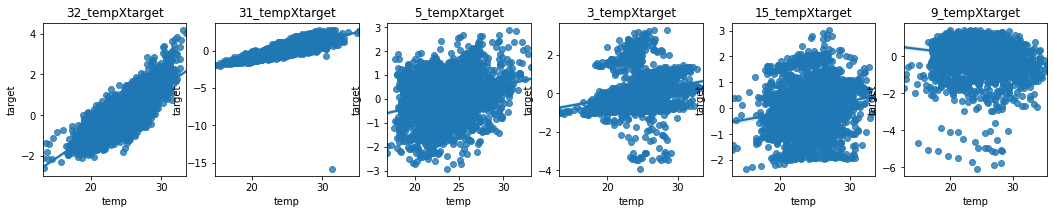

In [536]:
fig = plt.figure(figsize=(18, 40))
for i, n in enumerate(temp_sample):
    plt.subplot(12, 6, i+1)
    plt.title("{}_tempXtarget".format(n))
    sns.regplot(data=train.loc[train.num == n], x='temp', y='target')

32, 31번 건물은 아주 뚜렷한 양의 상관관계를 나타냅니다. 다른 건물들은 기온과는 큰 의미가 없어보이는 것이 눈에 띕니다.

### 2.4.3 습도의 영향을 많이 받는 건물

In [539]:
corrs_temp_temp = (corrs_cl_temp.humid_corr
                   .reset_index()
                   .sort_values(by=['humid_corr'], ascending=True)
                  .set_index(['num'], drop=False))

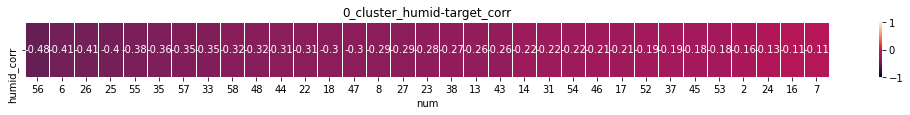

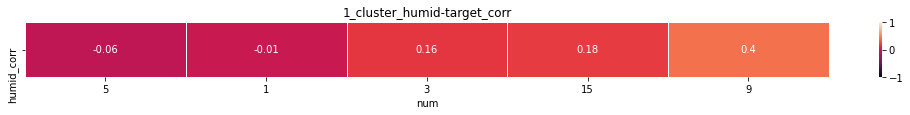

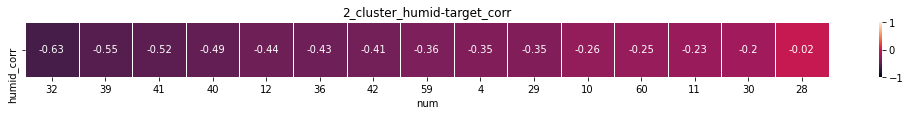

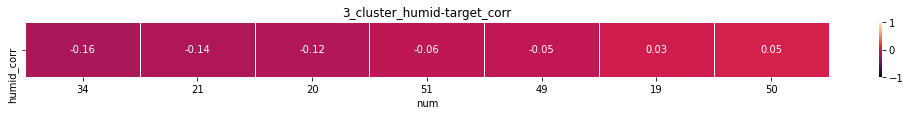

In [540]:
plt.figure(figsize=(18, 1))
plt.title('0_cluster_humid-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 0]['humid_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(18, 1))
plt.title('1_cluster_humid-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 1]['humid_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(18, 1))
plt.title('2_cluster_humid-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 2]['humid_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(18, 1))
plt.title('3_cluster_humid-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 3]['humid_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

- 0번 유형과 2번 유형은 건물별로 다양한 스펙트럼을 보입니다.
- 1번 유형은 9번을 제외하고는 습도에 따른 상관성을 보이지 않습니다.
- 9번 건물은 특이하게 양의 상관성을 띄고 있습니다.

높은 음의 상관성을 띄는 32, 39번과 상관성을 띄지 않는 50, 19번, 높은 양의 상관성을 띄는 9번과 15번을 추가로 살펴보겠습니다.

In [541]:
humid_sample = [32, 39, 50, 19, 9, 15]

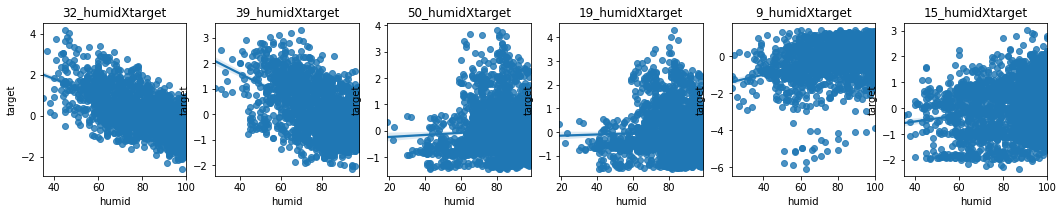

In [542]:
fig = plt.figure(figsize=(18, 40))
for i, n in enumerate(humid_sample):
    plt.subplot(12, 6, i+1)
    plt.title("{}_humidXtarget".format(n))
    sns.regplot(data=train.loc[train.num == n], x='humid', y='target')

### 2.4.4 바람의 영향을 많이 받는 건물

In [543]:
corrs_temp_temp = (corrs_cl_temp.wind_corr
                   .reset_index()
                   .sort_values(by=['wind_corr'], ascending=False)
                  .set_index(['num'], drop=False))

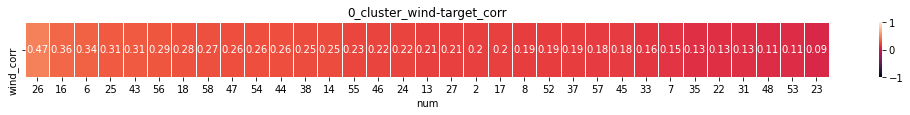

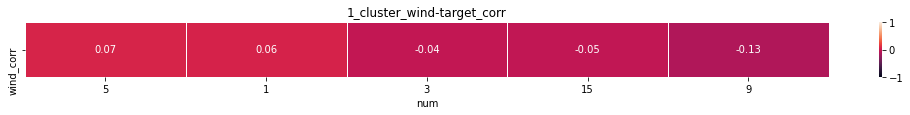

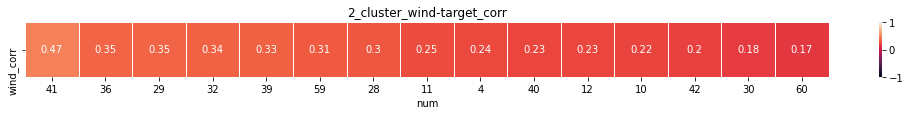

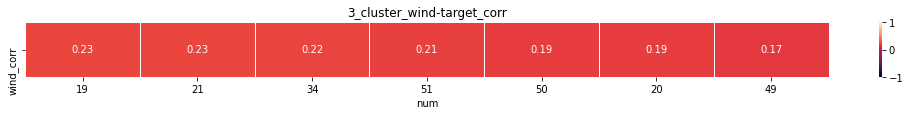

In [544]:
plt.figure(figsize=(18, 1))
plt.title('0_cluster_wind-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 0]['wind_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(18, 1))
plt.title('1_cluster_wind-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 1]['wind_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(18, 1))
plt.title('2_cluster_wind-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 2]['wind_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(18, 1))
plt.title('3_cluster_wind-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 3]['wind_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

- 여전히 0번, 2번 유형의 건물은 다양한 스펙트럼을 보입니다.
- 1번 유형의 건물들은 바람에도 큰 영향을 받지 않습니다.
- 3번 유형도 마찬가지로 크게 뚜렷한 상관성을 보이지 않습니다.

In [545]:
wind_sample = [26, 41, 19, 21, 5, 9]

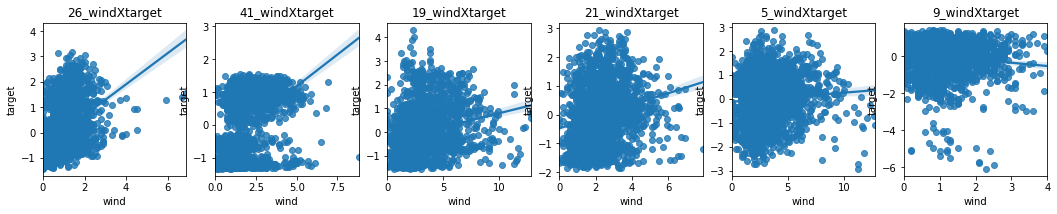

In [546]:
fig = plt.figure(figsize=(18, 40))
for i, n in enumerate(wind_sample):
    plt.subplot(12, 6, i+1)
    plt.title("{}_windXtarget".format(n))
    sns.regplot(data=train.loc[train.num == n], x='wind', y='target')

바람은 역시 전체적으로 유의미한 상관성을 보이지는 않고 있습니다.

### 2.4.5 정리

In [548]:
corrs_temp_temp = (corrs_cl_temp[['temp_corr', 'humid_corr', 'wind_corr']]
                   .reset_index()
                   .sort_values(by=['temp_corr', 'humid_corr', 'wind_corr'], ascending=False)
                  .set_index(['num'], drop=False))

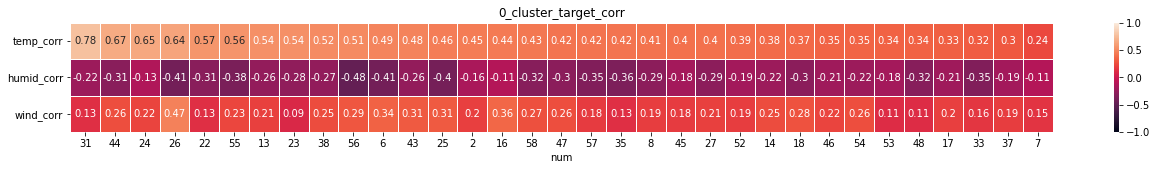

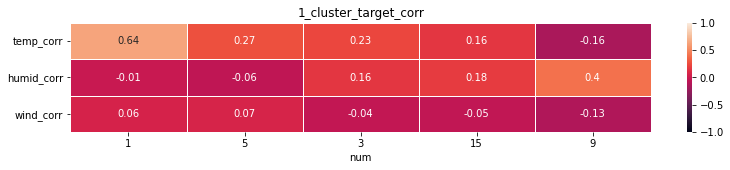

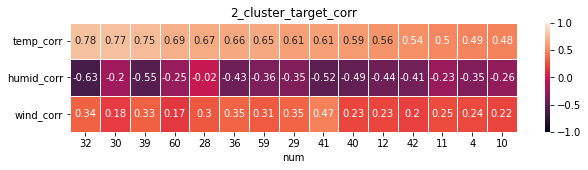

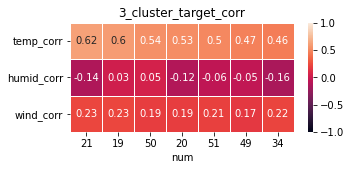

In [549]:
plt.figure(figsize=(22, 2))
plt.title('0_cluster_target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 0][['temp_corr','humid_corr', 'wind_corr']].T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(13, 2))
plt.title('1_cluster_target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 1][['temp_corr', 'humid_corr', 'wind_corr']].T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(10, 2))
plt.title('2_cluster_target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 2][['temp_corr', 'humid_corr', 'wind_corr']].T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(5, 2))
plt.title('3_cluster_target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 3][['temp_corr', 'humid_corr', 'wind_corr']].T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

- 기상의 영향을 많이 받는 건물이라면, 기온에 대한 양의 상관관계, 습도에 대한 음의 상관관계를 띄운다고 볼 수 있습니다.
- 대표적으로 2번 클러스터의 32번, 39번 건물이 있습니다.
- 반면에 기상의 영향을 많이 받지 않는 건물이 있는데, 주로 1번 유형의 건물들이라고 볼 수 있습니다.
- 1번 유형의 건물들 중 3, 5, 15 건물은 기온과 습도에 대한 뚜렷한 상관성을 보이지 않고 있습니다.
- 9번 건물은 특이하게도 습도에 대한 양의 상관관계를 가지고 있습니다.
- 1번 건물은 특이하게도 습도와 바람과는 상관없이 오직 기온에 대해서만 높은 상관성을 띄고 있습니다.
- 바람에 대한 상관계수는 0.45를 넘는 26번, 41번을 제외하고는 0.35 이하이기 때문에 뚜렷한 상관성을 띈다고는 볼 수 없습니다.

기상의 영향을 많이 받는 건물은 기상 예보 데이터를 통해 전력 사용량 예측이 가능할 것입니다.<br>
또한 이러한 건물의 경우 기상의 영향을 낮출 수 있는 방법을 통해 전력 사용량을 낮출 수 있을 것입니다.<br>

## 2.5 건물 시스템 변수에 대한 상관 분석: Cooler와 Solar는 효과가 있을까?

본 데이터에서 유일하게 건물의 정보로 제공된 비전기 냉방 시스템 설치 여부(Cooler), 태양광 발전 시스템 설치 여부(Solar)는 전력 소모량을 줄일 수 있는 시스템입니다.

- Cooler: 전기 소모 없이 냉방을 하여 전력 소모 절약
- Solar: 태양광 발전을 통해 전력 소모 절약

즉, 이 두 시스템이 설치 된 건물이 다른 건물보다 유의미한 차이가 있는지 살펴보고자 합니다.

### 2.5.1 건물 유형별 설치 여부 확인

In [570]:
cs_temp = train_cl.groupby(['km_cluster', 'num']).max().reset_index().groupby(['km_cluster'])['cooler', 'solar'].sum()

In [571]:
double_temp = train_cl[['km_cluster', 'num', 'solar', 'cooler']].drop_duplicates().set_index('num')
double_temp['double'] = double_temp.solar + double_temp.cooler

In [572]:
cs_temp['double'] = double_temp.loc[double_temp.double == 2].km_cluster.value_counts()

In [573]:
cs_temp['buildings'] = train_cl.groupby(['km_cluster'])['num'].count()/2040

In [574]:
cs_temp['cooler_rate'] = cs_temp.cooler / cs_temp.buildings
cs_temp['solar_rate'] = cs_temp.solar / cs_temp.buildings
cs_temp['double_rate'] = cs_temp.double / cs_temp.buildings

In [575]:
cs_temp

cooler  solar  double  buildings  cooler_rate  solar_rate  \
km_cluster                                                              
0             26.0   16.0      12       33.0     0.787879    0.484848   
1              3.0    2.0       1        5.0     0.600000    0.400000   
2             11.0    8.0       7       15.0     0.733333    0.533333   
3              1.0    3.0       1        7.0     0.142857    0.428571   

            double_rate  
km_cluster               
0              0.363636  
1              0.200000  
2              0.466667  
3              0.142857

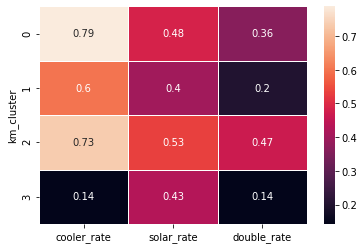

In [576]:
sns.heatmap(cs_temp[['cooler_rate', 'solar_rate', 'double_rate']],
           annot=True, linewidths=.5)
plt.show()

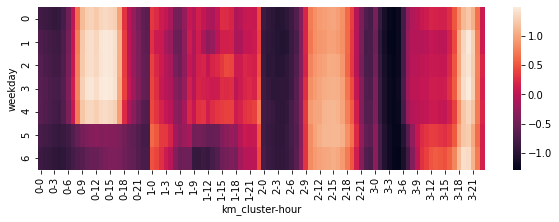

In [578]:
# 클러스터들이 어떤 유형의 건물들이었는지 까먹어서 다시 불러온 코드
plt.figure(figsize=(10, 3))
sns.heatmap(train_cl.groupby(['km_cluster', 'hour', 'weekday'])['target'].mean().unstack().T)
plt.show()

- solar는 모든 건물 유형에서 유사한 비율을 가지고 있습니다.
- cooler는 유형별로 매우 편차가 큽니다.
- 0번 유형은 79%가 설치한 반면, 3번 유형은 14%만 설치하였습니다.
- 주간에 전력사용량이 집중되어 있는 0, 2번 클러스터의 경우 cooler의 설치 비율이 높고, 밤에 주로 영업을 하는 3번 유형은 cooler를 설치하지 않은 것으로 보입니다.

### 2.5.2. 건물별 상관계수 분석

- Cooler는 기온이 높아질수록 냉방이 필요할테니 temp와의 상관계수 계산
- Solar는 일조시간이 길어질수록 전력 생산량이 늘어날테니 sunny와의 상관계수 계산

In [131]:
corrs_system_temp = (corrs_cl_temp[['cooler', 'temp_corr', 'sunny_corr', 'solar']]
                   .reset_index()
                   .sort_values(by=['cooler', 'solar'], ascending=False)
                  .set_index(['num'], drop=False))

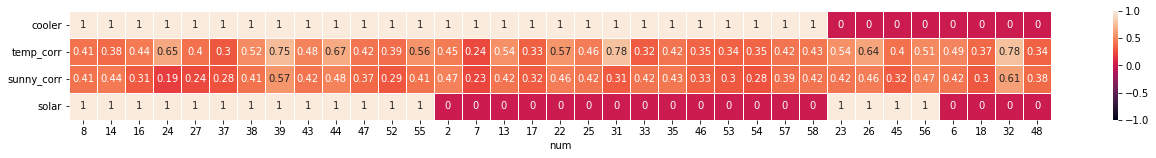

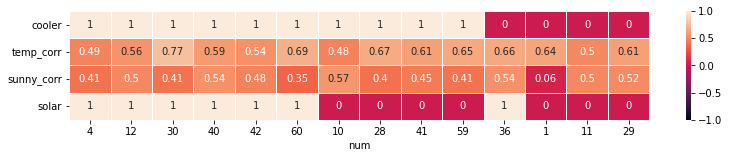

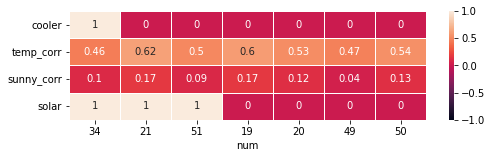

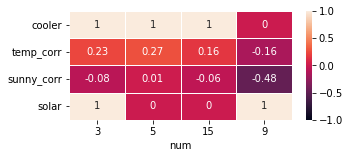

In [138]:
plt.figure(figsize=(22, 2))
sns.heatmap(corrs_system_temp.loc[corrs_system_temp.km_cluster == 0][['cooler', 'temp_corr', 'sunny_corr', 'solar']].T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(13, 2))
sns.heatmap(corrs_system_temp.loc[corrs_system_temp.km_cluster == 1][['cooler', 'temp_corr', 'sunny_corr', 'solar']].T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(8, 2))
sns.heatmap(corrs_system_temp.loc[corrs_system_temp.km_cluster == 2][['cooler', 'temp_corr', 'sunny_corr', 'solar']].T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(5, 2))
sns.heatmap(corrs_system_temp.loc[corrs_system_temp.km_cluster == 3][['cooler', 'temp_corr', 'sunny_corr', 'solar']].T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

- 이렇게 보아서는 뚜렷한 관계성을 찾아볼 수 없습니다.

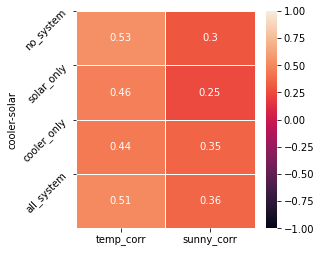

In [156]:
plt.figure(figsize=(4, 4))
sns.heatmap(corrs_cl_temp.groupby(['cooler', 'solar'])[['temp_corr', 'sunny_corr']].mean(),
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.yticks([0, 1, 2, 3], ['no_system', 'solar_only', 'cooler_only', 'all_system'], rotation=45)
plt.show()

- 설치 여부에 따른 건물 유형별로 평균을 비교해봐도 뚜렷한 차이를 알 수 없습니다.

### 2.5.3 피크 시간 비교

#### 2.5.3.1 냉방 시스템

동일한 시간대의 다른 날의 기온에 다른 전력 사용량을 비교하겠습니다.

In [235]:
peak_df_0_1 = train_cl.loc[(train_cl.weekday == 2) & (train_cl.hour == 14) & (train_cl.cooler == 1)]
peak_df_0_0 = train_cl.loc[(train_cl.weekday == 2) & (train_cl.hour == 14) & (train_cl.cooler == 0)]

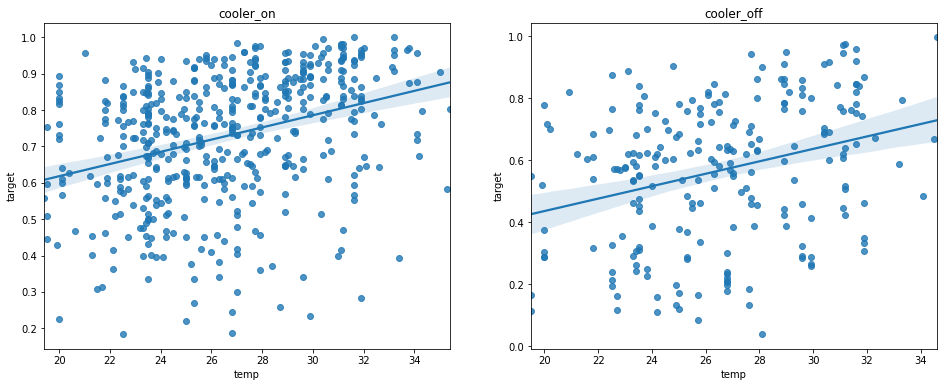

In [303]:
fig = plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.title("cooler_on")
sns.regplot(data=peak_df_0_1, x='temp', y='target')

plt.subplot(1, 2, 2)
plt.title("cooler_off")
sns.regplot(data=peak_df_0_0, x='temp', y='target')

plt.show()

- Cooler를 설치한 건물과 설치하지 않은 건물의 뚜렷한 차이는 보이지 않습니다.
- 다만 주목할 만 한 점은 Cooler를 설치한 건물은 기온 대비 전력 소모량이 유독 높게 형성이 되어 있다는 점입니다.
- 즉, Cooler를 설치하지 않은 건물들 대비, 절대적인 전력 소모량이 많은 건물들일 가능성이 높습니다.

건물들을 하나씩 살펴보겠습니다.

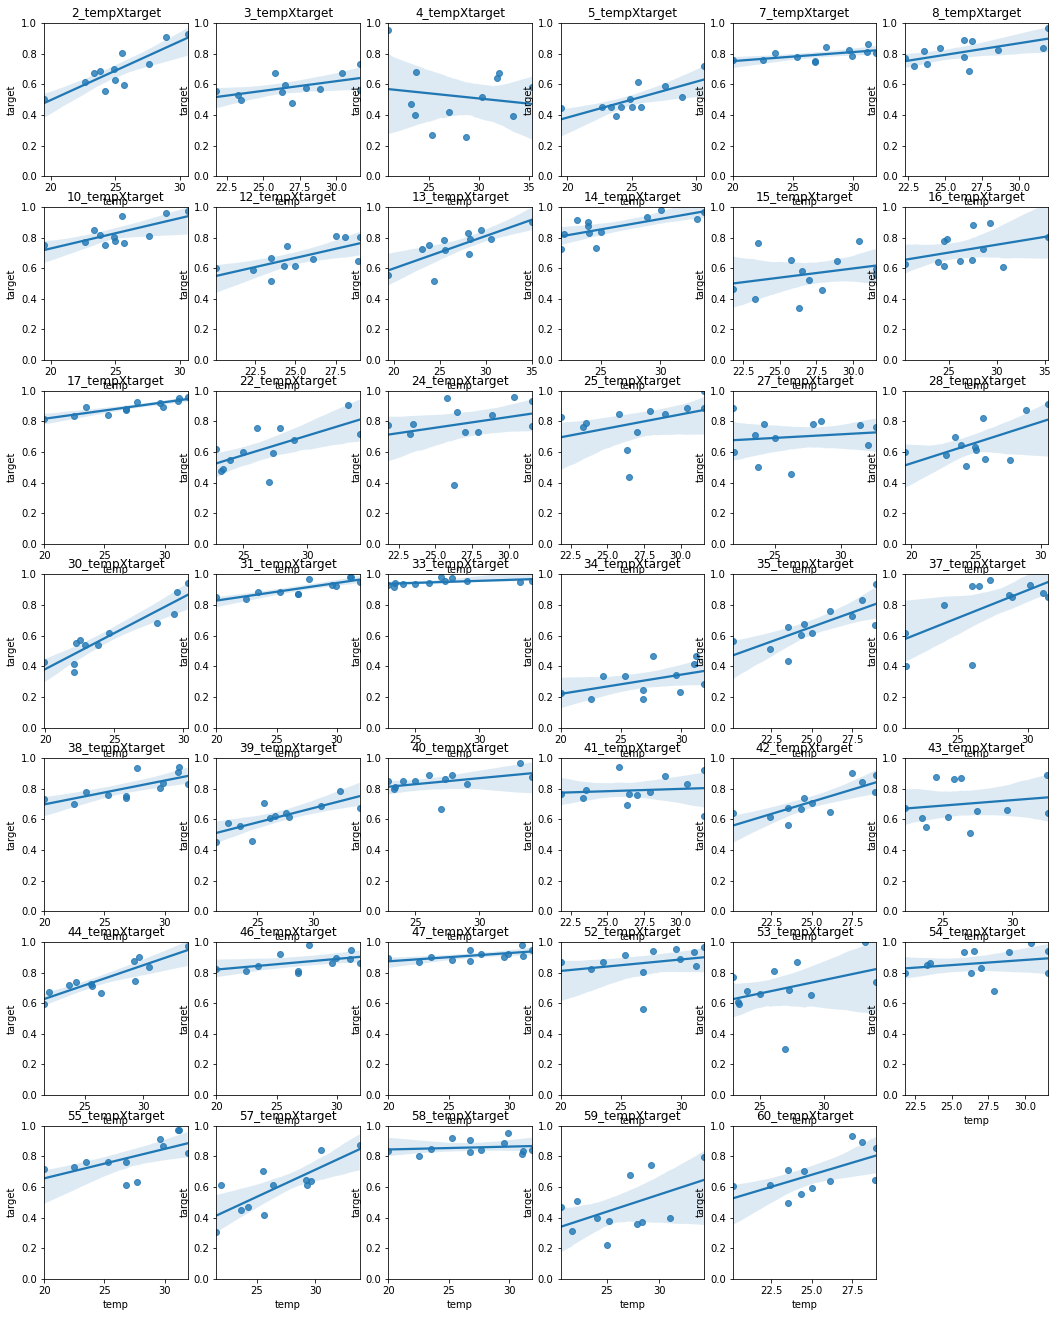

In [236]:
fig = plt.figure(figsize=(18, 40))
for i, n in enumerate(peak_df_0_1.num.unique()):
    plt.subplot(12, 6, i+1)
    plt.title("{}_tempXtarget".format(n))
    sns.regplot(data=peak_df_0_1.loc[peak_df_0_1.num == n], x='temp', y='target')
    plt.ylim(top=1, bottom=0)

대다수의 건물들의 플롯이 상단에 형성되어 있는 것을 볼 수 있습니다.

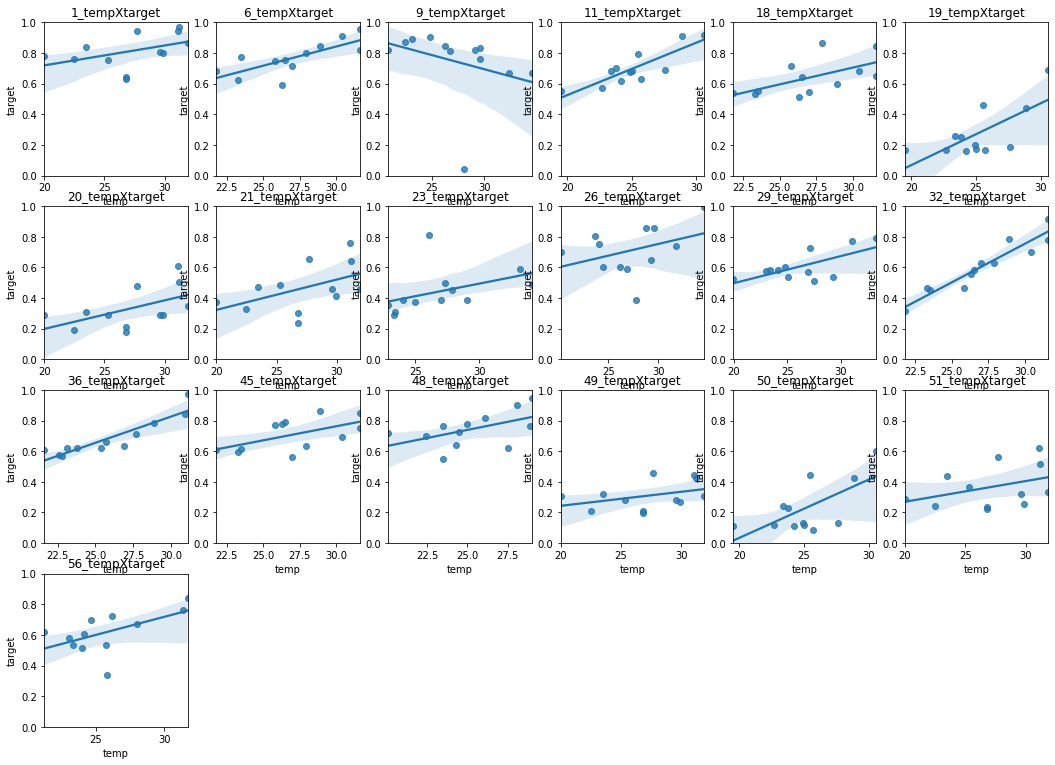

In [237]:
fig = plt.figure(figsize=(18, 40))
for i, n in enumerate(peak_df_0_0.num.unique()):
    plt.subplot(12, 6, i+1)
    plt.title("{}_tempXtarget".format(n))
    sns.regplot(data=peak_df_0_0.loc[peak_df_0_0.num == n], x='temp', y='target')
    plt.ylim(top=1, bottom=0)

반면에 Cooler를 설치하지 않은 건물들은 상대적으로 절대적인 전력 소모량이 적은 것을 알 수 있습니다.

- 정리하자면, Cooler를 설치한 건물들과 설치하지 않은 건물들에서 설치 여부에 따른 전력 소모량 차이는 크지 않아 보입니다.
- 그러나 Cooler를 설치한 건물들은 설치하지 않은 건물보다 절대적인 전력 소모량이 많은 것으로 파악됩니다.
- Cooler 설치 여부에 따른 전력 소모량의 관계를 정확히 밝혀낼 수는 없지만, 전력 소모량이 많은 건물들 위주로 Cooler를 설치했다는 것을 유추할 수 있습니다.

#### 2.5.3.2 태양광 시스템

태양광 발전 시스템은 태양광을 통해서 전력을 생산하고 즉시 사용하는 시스템입니다.

따라서 일조시간이 길어지는 날에는 일조시간이 적은 날보다 전력 소모량이 적을 것으로 추측할 수 있습니다.

이를 비교하기 위해서는 기온이 비슷하지만 일조 시간이 다른 두 날을 비교해보는 것입니다.(물론 다른 변수를 차단할 수 없어서 완벽한 분석은 불가능합니다.)

In [238]:
solar_temp = train_cl.groupby(['km_cluster', 'num', 'dayofyear'])[['target', 'sunny', 'solar']].sum().reset_index()

In [239]:
peak_df_1_1 = solar_temp.loc[solar_temp.solar != 0]
peak_df_1_0 = solar_temp.loc[solar_temp.solar == 0]

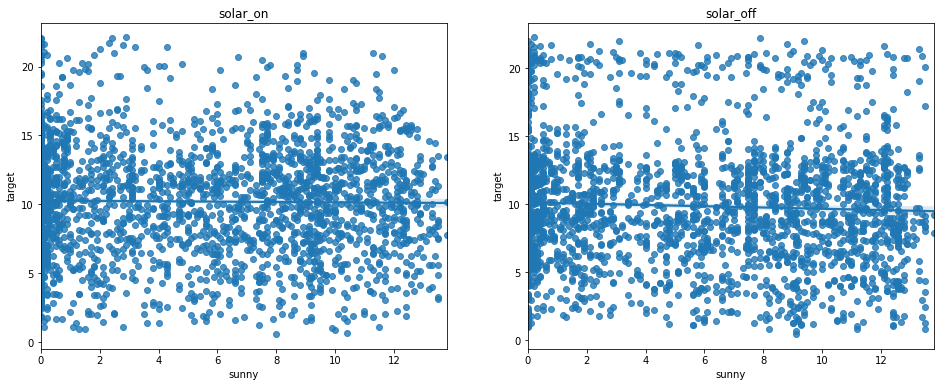

In [304]:
fig = plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.title("solar_on")
sns.regplot(data=peak_df_1_1, x='sunny', y='target')

plt.subplot(1, 2, 2)
plt.title("solar_off")
sns.regplot(data=peak_df_1_0, x='sunny', y='target')

plt.show()

태양광 시스템 설치 여부로는 일조시간과 전력 소모량의 유의미한 차이가 보이지 않습니다.

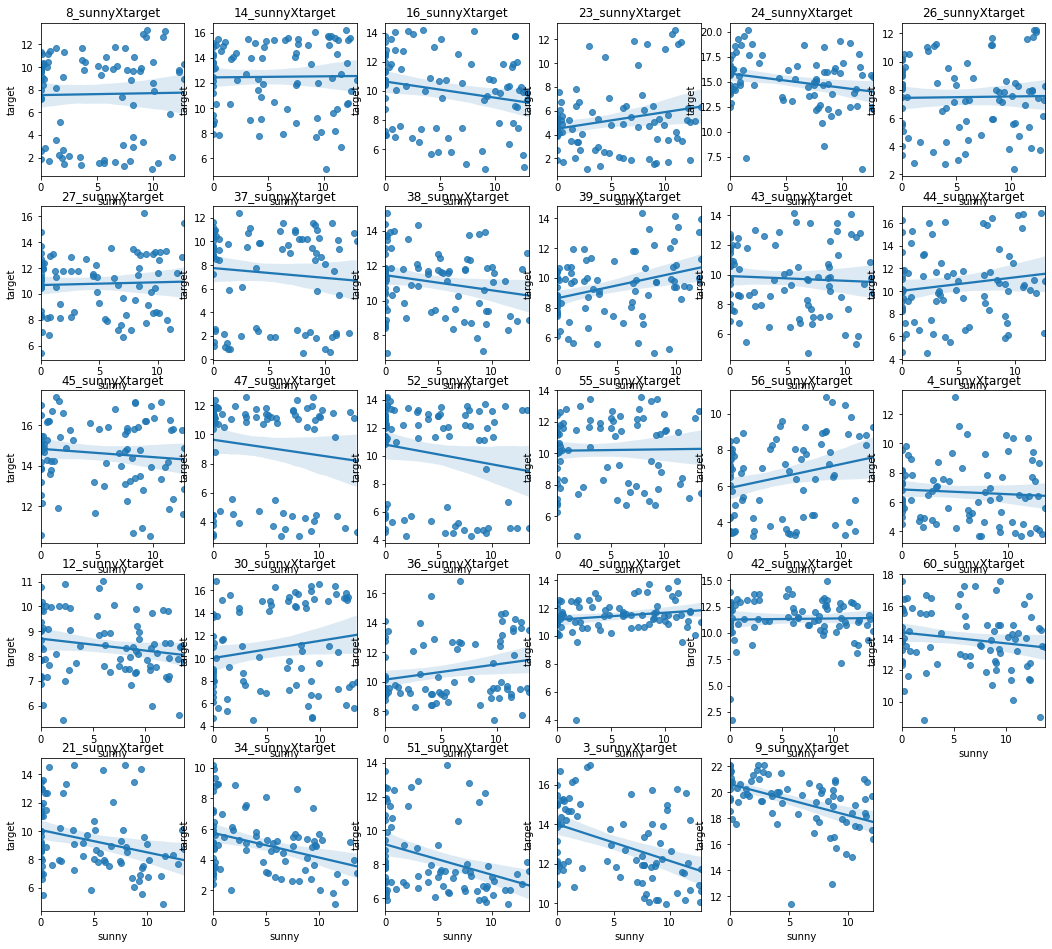

In [233]:
fig = plt.figure(figsize=(18, 40))
for i, n in enumerate(peak_df_1_1.num.unique()):
    plt.subplot(12, 6, i+1)
    plt.title("{}_sunnyXtarget".format(n))
    sns.regplot(data=peak_df_1_1.loc[peak_df_1_1.num == n], x='sunny', y='target')

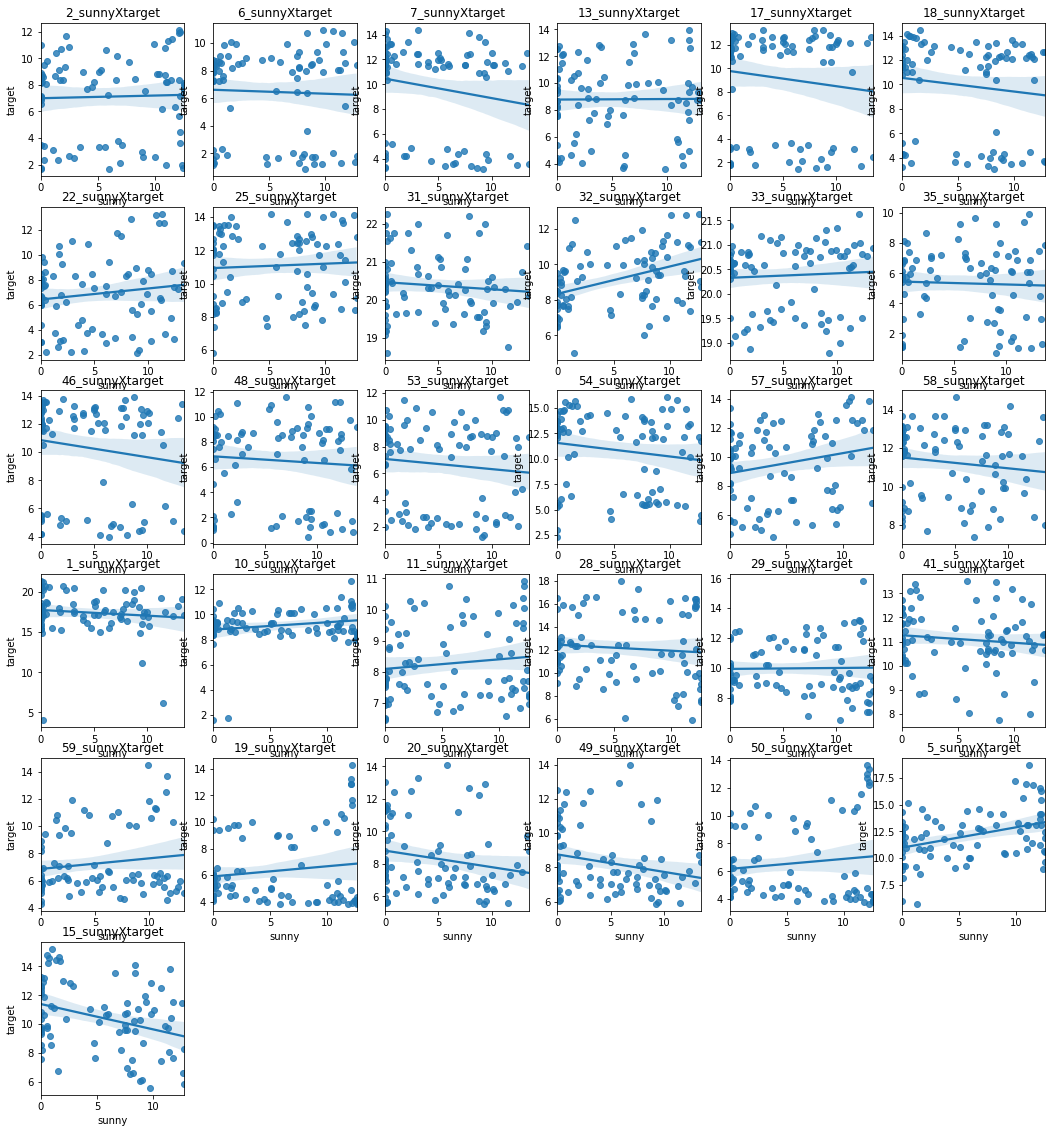

In [234]:
fig = plt.figure(figsize=(18, 40))
for i, n in enumerate(peak_df_1_0.num.unique()):
    plt.subplot(12, 6, i+1)
    plt.title("{}_sunnyXtarget".format(n))
    sns.regplot(data=peak_df_1_0.loc[peak_df_1_0.num == n], x='sunny', y='target')

건물별로 살펴보아도 명확히 구분짓지 못하겠습니다. 태양광 발전 시스템의 경우 심도 있는 고민이 필요할 것으로 보입니다.<br>
태양광 발전 시스템으로 인해 생산하는 전력량이 어느 정도인지, 생산한 전기를 즉시 사용하는지, Lag가 있는지도 중요할 것으로 보입니다.

# 3. 모델링

ARIMA 베이스라인 활용

In [622]:
#Library Imports
import numpy as np
import pandas as pd
import math
import os
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error


#######통계 라이브러리##########
from statsmodels.tsa.arima.model import ARIMA

In [623]:
train = pd.read_csv(PATH + '\\train.csv', encoding='cp949', names=train_col, header=0)

In [624]:
def make_time(train):
    train['date_time'] = pd.to_datetime(train.date_time)
    
    train['day'] = train.date_time.dt.day                        # 일(숫자)
    train['hour'] = train.date_time.dt.hour                      # 시(숫자)
    train['weekday'] = train.date_time.dt.weekday                # 시(숫자)
    
    return train

In [625]:
train = make_time(train)

In [640]:
X = train.loc[train.date_time < '2020-08-18']
y = train.loc[train.date_time >= '2020-08-18', ~train.columns.isin(['target'])]
true = train.loc[train.date_time >= '2020-08-18'].target

In [641]:
#2d의 데이터프레임을 건물별 정보를 반영한 3d 데이터로 변환
def df2d_to_array3d(df_2d):
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d['date_time'].value_counts())
    sample_size = len(df_2d.num.value_counts())
    
    return df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])

In [642]:
train_x_array=df2d_to_array3d(X)
test_x_array=df2d_to_array3d(y)

In [643]:
print(train_x_array.shape)
print(test_x_array.shape)

(60, 1872, 11)
(60, 168, 10)


In [644]:
def plot_series(x_series, y_series):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
             y_series, label = 'output_series')
    plt.axhline(1, c = 'red')
    plt.legend()

In [645]:
idx=1
x_series=train_x_array[idx, :, 0]
model=ARIMA(x_series, order=(3, 0, 1))
fit=model.fit()

In [646]:
preds=fit.predict(1, 168, typ='levels')

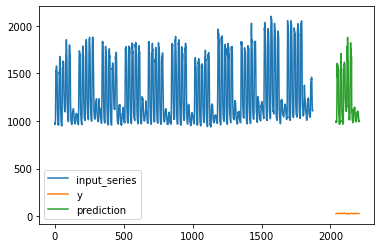

In [647]:
plt.plot(x_series, label = 'input_series')
plt.plot(np.arange(2040, 2040+168), test_x_array[idx, :, 0], label='y')
plt.plot(np.arange(2040, 2040+168), preds, label='prediction')
plt.legend()

In [650]:
valid_pred_array=np.zeros([60, 168])
for idx in range(train_x_array.shape[0]):
    try:
        try:
            x_series=train_x_array[idx, :, 0]
            model=ARIMA(x_series, order=(5, 1, 1))
            fit=model.fit()
            preds=fit.predict(1, 168, typ='levels')
            valid_pred_array[idx, :]=preds
        except:
            print("order 4,1,1")
            
            x_series=train_x_array[idx, :, 0]
            model=ARIMA(x_series, order=(4, 1, 1))
            fit=model.fit()
            preds=fit.predict(1, 168, typ='levels')
            valid_pred_array[idx, :]=preds
    except:
        print(idx, "샘플은 수렴하지 않습니다.")

In [404]:
sub.answer = valid_pred_array.reshape([-1,1])

In [406]:
sub

num_date_time       answer
0       1 2020-08-25 00  8177.884037
1       1 2020-08-25 01  8141.515251
2       1 2020-08-25 02  8107.113325
3       1 2020-08-25 03  8048.541587
4       1 2020-08-25 04  8036.527878
...                 ...          ...
10075  60 2020-08-31 19  3139.810899
10076  60 2020-08-31 20  3124.444612
10077  60 2020-08-31 21  3164.565676
10078  60 2020-08-31 22  2996.758219
10079  60 2020-08-31 23  2877.049156

[10080 rows x 2 columns]

In [657]:
preds = valid_pred_array.reshape([-1,1])

In [661]:
predict_df = y[['num', 'date_time']]
predict_df['target'] = true
predict_df['preds'] = preds

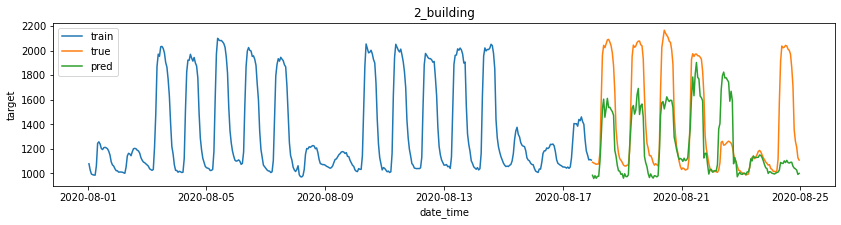

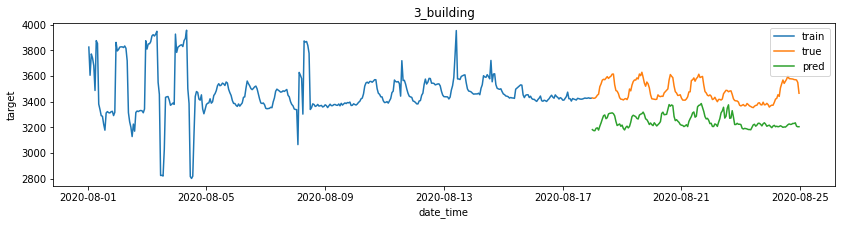

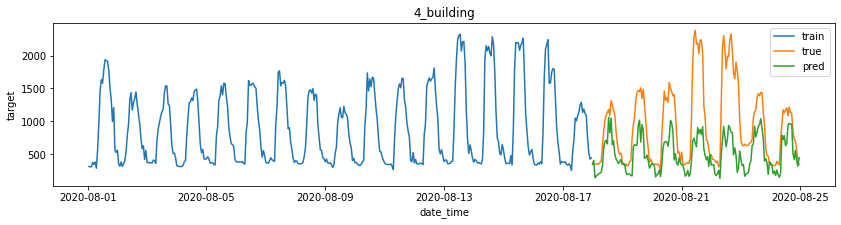

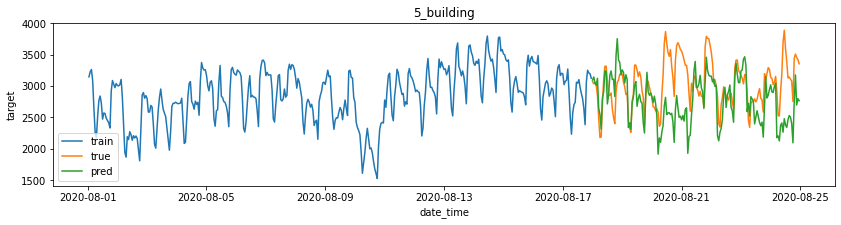

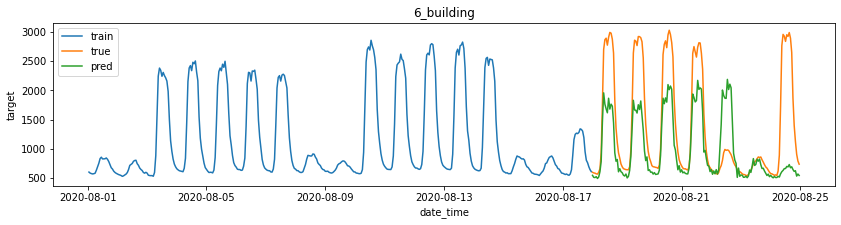

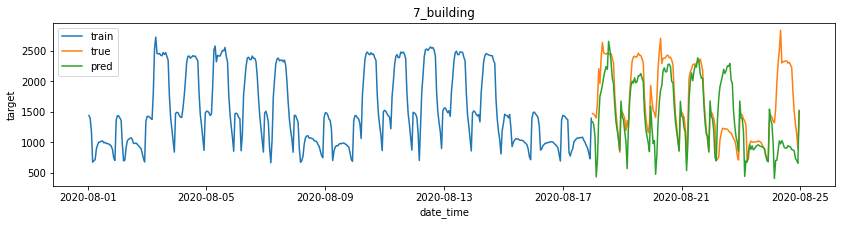

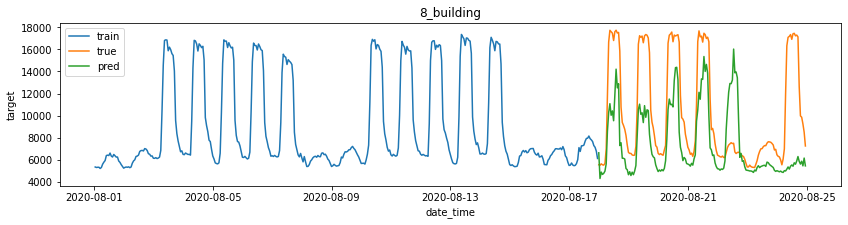

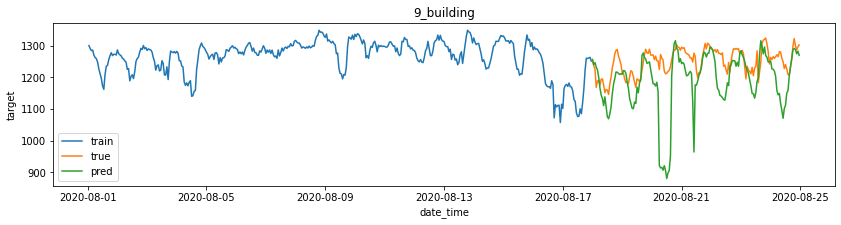

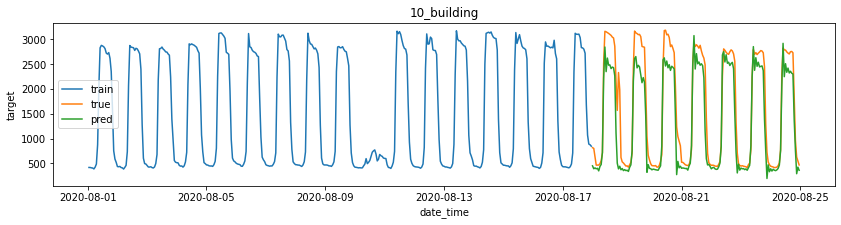

In [667]:
for i in range(2, 11):
    plt.figure(figsize=(14, 3))
    sns.lineplot(data=X.loc[(X.num == i) & (X.date_time > '2020-08-01')], x='date_time', y='target')
    sns.lineplot(data=predict_df.loc[predict_df.num == i], x='date_time', y='target')
    sns.lineplot(data=predict_df.loc[predict_df.num == i], x='date_time', y='preds')
    plt.legend(['train', 'true', 'pred'])
    plt.title('{}_building'.format(i))
    plt.show()

모델을 열심히 개선해야겠습니다. 대체로 과소예측하는 경향이 있습니다.

# 4. 최종 정리

주어진 변수를 최대한 활용하여 건물을 유형별로 정리하고, 변수의 상관성 등을 분석해 보았습니다.

분석을 통해 다음과 같은 결론을 도출할 수 있었습니다.

**1. 기상 요인을 강하게 받는 건물들과 받지 않는 건물들이 존재한다.**

In [674]:
temp_sample = [31, 32, 30, 3, 15, 9]

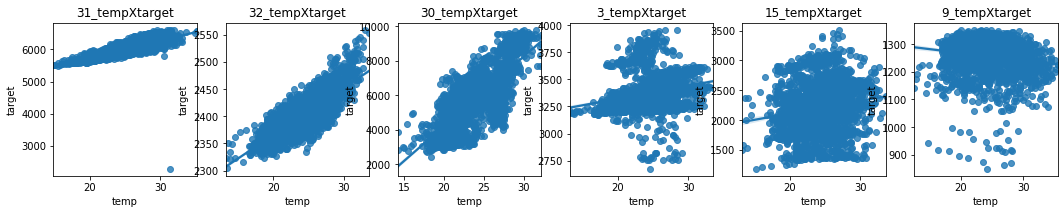

In [675]:
fig = plt.figure(figsize=(18, 40))
for i, n in enumerate(temp_sample):
    plt.subplot(12, 6, i+1)
    plt.title("{}_tempXtarget".format(n))
    sns.regplot(data=train.loc[train.num == n], x='temp', y='target')

In [669]:
humid_sample = [32, 39, 41, 5, 1, 9]

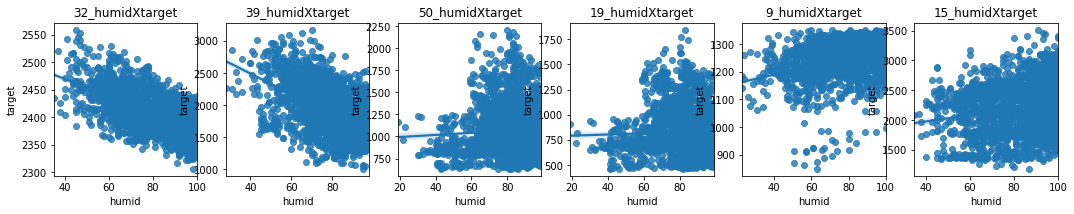

In [671]:
fig = plt.figure(figsize=(18, 40))
for i, n in enumerate(humid_sample):
    plt.subplot(12, 6, i+1)
    plt.title("{}_humidXtarget".format(n))
    sns.regplot(data=train.loc[train.num == n], x='humid', y='target')

**2. 요일, 시간 별로 패턴의 유사성을 보이는 건물들이 존재한다.**

In [678]:
cluster_sample = [2, 11, 20, 3]

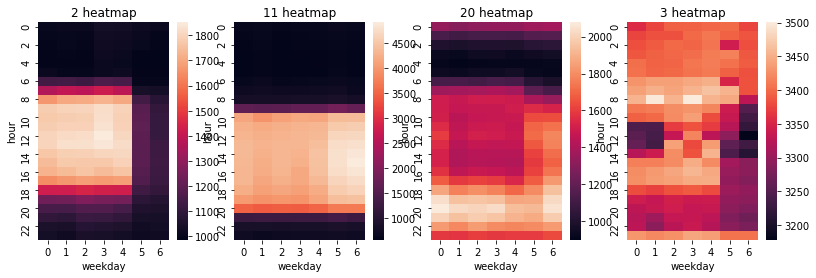

In [681]:
fig = plt.figure(figsize=(17, np.ceil(len(cluster_sample)/5)*4))
for i, n in enumerate(cluster_sample):
    plt.subplot(np.ceil(len(cluster_sample)/5), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

**3. 비전기냉방시스템과 태양광발전시스템의 영향을 조사할 수 있는 추가 변수가 필요하다.**

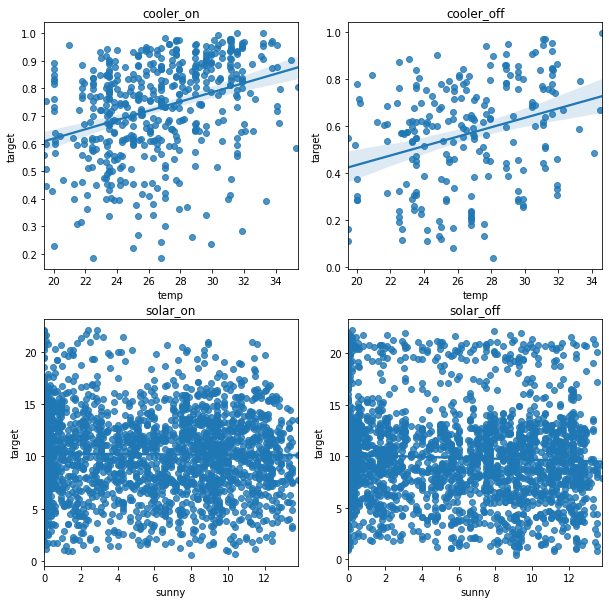

In [684]:
fig = plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.title("cooler_on")
sns.regplot(data=peak_df_0_1, x='temp', y='target')

plt.subplot(2, 2, 2)
plt.title("cooler_off")
sns.regplot(data=peak_df_0_0, x='temp', y='target')

plt.subplot(2, 2, 3)
plt.title("solar_on")
sns.regplot(data=peak_df_1_1, x='sunny', y='target')

plt.subplot(2, 2, 4)
plt.title("solar_off")
sns.regplot(data=peak_df_1_0, x='sunny', y='target')

plt.show()

1, 2번은 모델의 설명력을 높일 수 있는 힌트가 될 수 있으며,<br>
3번은 본 분석의 한계점이자, 대회 종료일까지 지속해서 고민해야 할 점입니다.

모델을 통해 각 건물의 전력 소모량에 대해 보다 정확한 예측이 가능하다면,<br>
전력 소모를 줄이기 위해 다방면으로 활용할 수 있을 것입니다.<br>

부족한 분석을 봐주셔서 정말 감사합니다. :)

이상, 끙정이었습니다.